# Optimize the design of the transmon pocket

To keep the structure roughly the same, we change the width of the metal pad in the transmon pocket. Intuitively, the wider the transmon pocket, the larger the capacitance would be. To increase the qubit frequency, we need to increase the capacitance.

## Steps
1. Construct the function that takes in padwidth and return a capacitance between ground and the metal pad
2. Function that takes in frequency and spit out desired capacitance
3. Optimize and find the desired design

In [1]:

import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from scipy import stats

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('Customized_Components')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

In [5]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

### Construct a single transmon pad to test the code

In [6]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '200um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '0um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

In [7]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [8]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [9]:
c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 09:25AM [connect_project]: Connecting to Ansys Desktop API...
INFO 09:25AM [load_ansys_project]: 	Opened Ansys App
INFO 09:25AM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 09:25AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project19
INFO 09:25AM [connect_design]: No active design found (or error getting active design).
INFO 09:25AM [connect]: 	 Connected to project "Project19". No design detected
INFO 09:25AM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 09:25AM [connect_setup]: 	No design setup detected.
WARNING 09:25AM [connect_setup]: 	Creating Q3D default setup.
INFO 09:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:25AM [analyze]: Analyzing setup Setup
INFO 09:26AM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Tem

In [10]:
c_mat

,a_connector_pad_Q1,ground_main_plane,pad_top_Q1
a_connector_pad_Q1,23.08703,-13.21651,-9.49272
ground_main_plane,-13.21651,122.26453,-67.33210
pad_top_Q1,-9.49272,-67.33210,80.27398


In [11]:
C = c_mat['ground_main_plane']['a_connector_pad_Q1']

In [12]:
C

-13.21651

### Sainity check the general trend of capacitance

This ensures that capacitance of the top pad to ground is a roughly linear funciton. 

In [21]:
def find_Cap(gap):
    if type(gap)== u.quantity.Quantity:
        gap = gap.to(u.um)
    elif type(gap) == np.ndarray:
        gap = gap[0]*u.um
    design.delete_all_components()
    
    width = 300*u.um-2*gap

    options = dict(pad_width = '{}'.format(width),
    pocket_width = '{}'.format(350*u.um),
    pad_pocket_distance_top = '30um',
    pos_x = '0',
    pad_height = '250um',
    jj_length = '30um',
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '15um',
                pad_width = '60um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '0')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 5
    c1.sim.setup.max_passes = 30
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return((-c_mat['ground_main_plane']['pad_top_Q1'])*u.fF, design)
    

In [30]:
find_Cap(15*u.um)

03:04PM 22s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 03:04PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:04PM [analyze]: Analyzing setup Setup
INFO 03:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8xpiewv0.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9yeekhbk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:05PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7mj6c440.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.50010          -13.03592    -5.29844
ground_main_plane            -13.03592          161.70666  -107.81632
pad_top_Q1                    -5.29844         -107.81632   118.18909


(<Quantity 107.81632 fF>,
 <qiskit_metal.designs.design_planar.DesignPlanar at 0x1e4a02b1390>)

In [9]:
from qiskit_metal.analyses.quantization import EPRanalysis
import pandas as pd

In [10]:
pd.read_csv('hfss_eig_f_convergence.csv')

,Pass [],re(Mode(1)) [g],re(Mode(2)) [g]
0,1,5.515139,52.311844
1,2,5.542447,51.779603
2,3,5.621863,51.816369
3,4,5.642735,51.542981
4,5,5.647502,51.699553
5,6,5.653217,51.786357
6,7,5.654396,51.528233
7,8,5.654809,51.836963
8,9,5.655888,51.527249
9,10,5.655953,51.808264


In [11]:
hfss = eig_qb.sim.renderer
hfss.clean_active_design()

NameError: name 'eig_qb' is not defined

INFO 01:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:16PM [analyze]: Analyzing setup Setup
INFO 01:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpb4mf3m9_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpaqkz3tp7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpow543fcc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9pfqq34t.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.50010          -13.03592    -5.29844
ground_main_plane            -13.03592          161.70666  -107.81632
pad_top_Q1                    -5.29844         -107.81632   118.18909
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:17PM [connect_design]: 	Opened active design
	Design:    Transmons_0_hfss [Solution type: Eigenmode]
INFO 01:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:17PM [analyze]: Analyzing setup Setup
01:19PM 09s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.6939851552375e-25
        energy_elec_substrate = 1.56163431074909e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.43232731984301e-27
        energy_mag % of energy_elec_all  = 1.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.81 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.6%   8.47e-26 1.216e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.46%
	jj1             0.336279  (+)        0.0159974
		(U_tot_cap-U_tot_ind)/mean=48.69%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218701273271465


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:19PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_0_hfss\2023-02-15 13-19-09.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.957811
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330984

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       442

*** Chi matrix ND (MHz) 
       507

*** Frequencies O1 PT (MHz)
0    6366.253618
dtype: float64

*** Frequencies ND (MHz)
0    6333.45132
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6333.45


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,506.81


Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_0_hfss" info:
	# eigenmodes    1
	# variations    1


01:19PM 17s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:19PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:19PM [analyze]: Analyzing setup Setup
INFO 01:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe0r3wjn5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfu0o3lu4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpjvq705tj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.66065          -13.17838    -5.31343
ground_main_plane            -13.17838          160.66126  -106.60482
pad_top_Q1                    -5.31343         -106.60482   116.95806
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:20PM [connect_design]: 	Opened active design
	Design:    Transmons_1_hfss [Solution type: Eigenmode]
INFO 01:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:20PM [analyze]: Analyzing setup Setup
01:21PM 50s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.53158311483266e-25
        energy_elec_substrate = 2.33357229178764e-25
        EPR of substrate = 92.2%

        energy_mag    = 3.64479299732884e-27
        energy_mag % of energy_elec_all  = 1.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.84 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.6%  1.266e-25 1.822e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.42%
	jj1             0.336266  (+)        0.0161382
		(U_tot_cap-U_tot_ind)/mean=48.69%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217837953315198


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:21PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_1_hfss\2023-02-15 13-21-50.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.958168
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330925

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       445

*** Chi matrix ND (MHz) 
       511

*** Frequencies O1 PT (MHz)
0    6392.418921
dtype: float64

*** Frequencies ND (MHz)
0    6359.168046
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6359.17


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,511.49


Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_1_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:21PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:22PM [analyze]: Analyzing setup Setup
INFO 01:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu55d070e.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpd7odycf1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6y9yf1w_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp51z3ky12.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            18.88254          -13.35529    -5.35521
ground_main_plane            -13.35529          159.76762  -105.50507
pad_top_Q1                    -5.35521         -105.50507   115.86863
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:22PM [connect_design]: 	Opened active design
	Design:    Transmons_2_hfss [Solution type: Eigenmode]
INFO 01:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:23PM [analyze]: Analyzing setup Setup
01:26PM 25s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 6.41224381693394e-26
        energy_elec_substrate = 5.91216791009556e-26
        EPR of substrate = 92.2%

        energy_mag    = 9.28933130314069e-28
        energy_mag % of energy_elec_all  = 1.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.88 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.6%  3.206e-26 4.645e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.37%
	jj1             0.336234  (+)        0.0163419
		(U_tot_cap-U_tot_ind)/mean=48.69%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.922012337472611


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:26PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:26PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:26PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_2_hfss\2023-02-15 13-26-26.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.958655
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330828

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       451

*** Chi matrix ND (MHz) 
       518

*** Frequencies O1 PT (MHz)
0    6430.206939
dtype: float64

*** Frequencies ND (MHz)
0    6396.310666
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6396.31


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,518.22


Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_2_hfss" info:
	# eigenmodes    1
	# variations    1


01:26PM 34s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:26PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:26PM [analyze]: Analyzing setup Setup
INFO 01:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl9nshton.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpa7pbtzcx.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:27PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpco9bkuap.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.06711          -13.52001    -5.37224
ground_main_plane            -13.52001          158.93348  -104.46910
pad_top_Q1                    -5.37224         -104.46910   114.81604
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:27PM [connect_design]: 	Opened active design
	Design:    Transmons_3_hfss [Solution type: Eigenmode]
INFO 01:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:27PM [analyze]: Analyzing setup Setup
01:30PM 07s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.35988698313869e-26
        energy_elec_substrate = 7.7072739965596e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.21077474980338e-27
        energy_mag % of energy_elec_all  = 1.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.91 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.6%   4.18e-26 6.054e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.33%
	jj1             0.336237  (+)        0.0164839
		(U_tot_cap-U_tot_ind)/mean=48.70%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219351902848251


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:30PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:30PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:30PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_3_hfss\2023-02-15 13-30-07.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.95907
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330784

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       455

*** Chi matrix ND (MHz) 
       523

*** Frequencies O1 PT (MHz)
0    6456.104923
dtype: float64

*** Frequencies ND (MHz)
0    6421.74093
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6421.74


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,523.01


Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_3_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:30PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:30PM [analyze]: Analyzing setup Setup
INFO 01:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl5nwi7q9.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpshjs8sm9.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplrmepybs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw0js3gvh.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.10580          -13.56476    -5.37171
ground_main_plane            -13.56476          157.81021  -103.06337
pad_top_Q1                    -5.37171         -103.06337   113.40537
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:31PM [connect_design]: 	Opened active design
	Design:    Transmons_4_hfss [Solution type: Eigenmode]
INFO 01:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:31PM [analyze]: Analyzing setup Setup
01:32PM 36s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.84898857987055e-25
        energy_elec_substrate = 1.70426324772066e-25
        EPR of substrate = 92.2%

        energy_mag    = 4.34473184904037e-27
        energy_mag % of energy_elec_all  = 2.3%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.94 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.7%  9.245e-26 2.172e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.30%
	jj1              0.33624  (+)          0.0166
		(U_tot_cap-U_tot_ind)/mean=47.73%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217272979803789


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:32PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:32PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:32PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_4_hfss\2023-02-15 13-32-37.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.9202
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330749

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.97

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       446

*** Chi matrix ND (MHz) 
       510

*** Frequencies O1 PT (MHz)
0    6489.201599
dtype: float64

*** Frequencies ND (MHz)
0    6456.961126
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6456.96


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,510.16


Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_4_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:32PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:32PM [analyze]: Analyzing setup Setup
INFO 01:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpevju1hc5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphh66lkfd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmple4_w4kc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:33PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu7ujflt6.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.30635          -13.73371    -5.40074
ground_main_plane            -13.73371          156.95447  -102.04643
pad_top_Q1                    -5.40074         -102.04643   112.38021
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:33PM [connect_design]: 	Opened active design
	Design:    Transmons_5_hfss [Solution type: Eigenmode]
INFO 01:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:33PM [analyze]: Analyzing setup Setup
01:36PM 24s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 7.79772905111181e-26
        energy_elec_substrate = 7.18939773099389e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.13529823919431e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 6.98 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  3.899e-26 5.676e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.24%
	jj1             0.336211  (+)        0.0168096
		(U_tot_cap-U_tot_ind)/mean=48.70%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219860915748049


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:36PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_5_hfss\2023-02-15 13-36-25.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.959926
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330653

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       464

*** Chi matrix ND (MHz) 
       534

*** Frequencies O1 PT (MHz)
0    6515.375465
dtype: float64

*** Frequencies ND (MHz)
0    6479.950031
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6479.95


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,533.87


Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_5_hfss" info:
	# eigenmodes    1
	# variations    1


01:36PM 32s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:36PM [analyze]: Analyzing setup Setup
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpas3gr_dt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmploaibr9m.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpnbp_o4sl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.49178          -13.88799    -5.42899
ground_main_plane            -13.88799          156.11065  -101.00836
pad_top_Q1                    -5.42899         -101.00836   111.34237
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:37PM [connect_design]: 	Opened active design
	Design:    Transmons_6_hfss [Solution type: Eigenmode]
INFO 01:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:37PM [analyze]: Analyzing setup Setup
01:39PM 09s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.38639385011293e-25
        energy_elec_substrate = 1.27801188414149e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.02005998553869e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.00 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  6.932e-26  1.01e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.21%
	jj1             0.336209  (+)        0.0169328
		(U_tot_cap-U_tot_ind)/mean=48.71%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.921824547935919


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:39PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:39PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:39PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_6_hfss\2023-02-15 13-39-09.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.96026
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330611

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       467

*** Chi matrix ND (MHz) 
       538

*** Frequencies O1 PT (MHz)
0    6537.538054
dtype: float64

*** Frequencies ND (MHz)
0    6501.704013
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6501.7


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,538.0


Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_6_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:39PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:39PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:39PM [analyze]: Analyzing setup Setup
INFO 01:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg0q4ot3w.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpkpg8ui8f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpml0ts6hg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:40PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpia8tykrl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            19.69382          -14.06450    -5.45197
ground_main_plane            -14.06450          155.20645   -99.91407
pad_top_Q1                    -5.45197          -99.91407   110.23467
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:40PM [connect_design]: 	Opened active design
	Design:    Transmons_7_hfss [Solution type: Eigenmode]
INFO 01:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:40PM [analyze]: Analyzing setup Setup
01:41PM 57s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.56321283435679e-25
        energy_elec_substrate = 1.44105499586086e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.28087498578967e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.04 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  7.816e-26  1.14e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.16%
	jj1               0.3362  (+)        0.0170986
		(U_tot_cap-U_tot_ind)/mean=48.71%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218546343715289


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:42PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:42PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_7_hfss\2023-02-15 13-41-57.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.960738
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330548

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       472

*** Chi matrix ND (MHz) 
       544

*** Frequencies O1 PT (MHz)
0    6567.281767
dtype: float64

*** Frequencies ND (MHz)
0    6530.895592
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6530.9


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,543.57


Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_7_hfss" info:
	# eigenmodes    1
	# variations    1


01:42PM 04s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:42PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:42PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:42PM [analyze]: Analyzing setup Setup
INFO 01:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvb7xo23i.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpmw4ulcw_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:42PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr0yls5dd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.03224          -14.33395    -5.50808
ground_main_plane            -14.33395          154.65712   -99.24792
pad_top_Q1                    -5.50808          -99.24792   109.56403
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:43PM [connect_design]: 	Opened active design
	Design:    Transmons_8_hfss [Solution type: Eigenmode]
INFO 01:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:43PM [analyze]: Analyzing setup Setup
01:44PM 36s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.73744444818397e-25
        energy_elec_substrate = 1.60148089692961e-25
        EPR of substrate = 92.2%

        energy_mag    = 4.16382209735508e-27
        energy_mag % of energy_elec_all  = 2.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.07 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.6%  8.687e-26 2.082e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 95.12%
	jj1             0.336212  (+)        0.0172476
		(U_tot_cap-U_tot_ind)/mean=47.70%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217450944135375


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:44PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:44PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:44PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_8_hfss\2023-02-15 13-44-36.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.920327
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330512

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.97

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       463

*** Chi matrix ND (MHz) 
       530

*** Frequencies O1 PT (MHz)
0    6606.666935
dtype: float64

*** Frequencies ND (MHz)
0    6572.546999
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6572.55


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,530.42


Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_8_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:44PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:44PM [analyze]: Analyzing setup Setup
INFO 01:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpi0v0lb_d.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy3a1g_ik.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw7_pup_7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw_yueuxc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.13401          -14.43549    -5.51553
ground_main_plane            -14.43549          153.71579   -98.02614
pad_top_Q1                    -5.51553          -98.02614   108.34829
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:45PM [connect_design]: 	Opened active design
	Design:    Transmons_9_hfss [Solution type: Eigenmode]
INFO 01:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:45PM [analyze]: Analyzing setup Setup
01:48PM 09s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.11354343321839e-26
        energy_elec_substrate = 7.48050726821595e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.19179098457754e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.11 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  4.057e-26 5.959e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.06%
	jj1             0.336162  (+)        0.0174528
		(U_tot_cap-U_tot_ind)/mean=48.72%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219778423308034


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:48PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:48PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_9_hfss\2023-02-15 13-48-09.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.96169
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330396

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       481

*** Chi matrix ND (MHz) 
       555

*** Frequencies O1 PT (MHz)
0    6630.533983
dtype: float64

*** Frequencies ND (MHz)
0    6592.971377
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6592.97


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,555.4


Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_9_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:48PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:48PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:48PM [analyze]: Analyzing setup Setup
INFO 01:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp6gwspifq.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo_wpab6r.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpll26mlt0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:49PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo50v92kw.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.30502          -14.59069    -5.52966
ground_main_plane            -14.59069          152.99962   -97.05705
pad_top_Q1                    -5.52966          -97.05705   107.35069
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:49PM [connect_design]: 	Opened active design
	Design:    Transmons_10_hfss [Solution type: Eigenmode]
INFO 01:49PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:49PM [analyze]: Analyzing setup Setup
01:51PM 47s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.01210570795293e-26
        energy_elec_substrate = 7.38714109622689e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.18023519252183e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.15 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  4.006e-26 5.901e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 95.02%
	jj1             0.336156  (+)        0.0176199
		(U_tot_cap-U_tot_ind)/mean=48.72%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219974580333243


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:51PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:51PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:51PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.4% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_10_hfss\2023-02-15 13-51-48.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.962056
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330335

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       486

*** Chi matrix ND (MHz) 
       561

*** Frequencies O1 PT (MHz)
0    6660.00546
dtype: float64

*** Frequencies ND (MHz)
0    6621.883915
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6621.88


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,560.97


Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_10_hfss" info:
	# eigenmodes    1
	# variations    1


01:51PM 55s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:51PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:52PM [analyze]: Analyzing setup Setup
INFO 01:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprpivca1t.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpedcwm7i0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:52PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp_es3j4la.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.46375          -14.72266    -5.55329
ground_main_plane            -14.72266          152.18464   -96.08215
pad_top_Q1                    -5.55329          -96.08215   106.36714
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:52PM [connect_design]: 	Opened active design
	Design:    Transmons_11_hfss [Solution type: Eigenmode]
INFO 01:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:52PM [analyze]: Analyzing setup Setup
01:54PM 28s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.5518850574242e-25
        energy_elec_substrate = 1.43054249207654e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.28486402434808e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.17 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  7.759e-26 1.142e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.98%
	jj1             0.336155  (+)        0.0177516
		(U_tot_cap-U_tot_ind)/mean=48.73%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218095665222379


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:54PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:54PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:54PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_11_hfss\2023-02-15 13-54-28.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.962485
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330292

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       490

*** Chi matrix ND (MHz) 
       565

*** Frequencies O1 PT (MHz)
0    6683.011383
dtype: float64

*** Frequencies ND (MHz)
0    6644.435272
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6644.44


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,565.44


Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_11_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 01:54PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:54PM [analyze]: Analyzing setup Setup
INFO 01:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpypyii_6v.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe337gmig.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplt03h5pd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:55PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphfyr2yvs.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.65174          -14.87861    -5.58215
ground_main_plane            -14.87861          151.37363   -95.09041
pad_top_Q1                    -5.58215          -95.09041   105.37315
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:55PM [connect_design]: 	Opened active design
	Design:    Transmons_12_hfss [Solution type: Eigenmode]
INFO 01:55PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:55PM [analyze]: Analyzing setup Setup
01:57PM 35s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.06985677705803e-25
        energy_elec_substrate = 9.86307672368083e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.57970231280653e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.21 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  5.349e-26 7.899e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.93%
	jj1             0.336142  (+)        0.017942
		(U_tot_cap-U_tot_ind)/mean=48.73%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219062714920624


  options=pd.Series(get_instance_vars(self.options)),

WARNING 01:57PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 01:57PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 01:57PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_12_hfss\2023-02-15 13-57-36.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.962978
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330217

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       495

*** Chi matrix ND (MHz) 
       572

*** Frequencies O1 PT (MHz)
0    6716.301322
dtype: float64

*** Frequencies ND (MHz)
0    6677.079219
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6677.08


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,571.82


Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_12_hfss" info:
	# eigenmodes    1
	# variations    1


01:57PM 43s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 01:57PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 01:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:57PM [analyze]: Analyzing setup Setup
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0y7bfkpz.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8dlpbxwe.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg_jvoh30.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.81923          -15.03158    -5.59382
ground_main_plane            -15.03158          150.58258   -94.10119
pad_top_Q1                    -5.59382          -94.10119   104.36301
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 01:58PM [connect_design]: 	Opened active design
	Design:    Transmons_13_hfss [Solution type: Eigenmode]
INFO 01:58PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 01:58PM [analyze]: Analyzing setup Setup
02:00PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.04185588333875e-25
        energy_elec_substrate = 1.88234335023922e-25
        EPR of substrate = 92.2%

        energy_mag    = 3.02294126007957e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.24 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  1.021e-25 1.511e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.89%
	jj1             0.336128  (+)        0.018106
		(U_tot_cap-U_tot_ind)/mean=48.73%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218786524547941


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:00PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:00PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:00PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_13_hfss\2023-02-15 14-00-39.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.963411
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330151

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       499

*** Chi matrix ND (MHz) 
       577

*** Frequencies O1 PT (MHz)
0    6744.852076
dtype: float64

*** Frequencies ND (MHz)
0    6705.070709
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6705.07


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,577.31


Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_13_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:00PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:00PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:00PM [analyze]: Analyzing setup Setup
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpyl9yula7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc6au8ej4.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpqqrow6ib.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:01PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzwh06up7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            20.99499          -15.17389    -5.62416
ground_main_plane            -15.17389          149.80173   -93.16236
pad_top_Q1                    -5.62416          -93.16236   103.42015
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:01PM [connect_design]: 	Opened active design
	Design:    Transmons_14_hfss [Solution type: Eigenmode]
INFO 02:01PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:01PM [analyze]: Analyzing setup Setup
02:03PM 04s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.52782819490592e-25
        energy_elec_substrate = 2.33016794984376e-25
        EPR of substrate = 92.2%

        energy_mag    = 5.57959598680829e-27
        energy_mag % of energy_elec_all  = 2.2%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.27 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.8%  1.264e-25  2.79e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.85%
	jj1             0.336133  (+)        0.0182499
		(U_tot_cap-U_tot_ind)/mean=47.95%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218062978091293


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:03PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:03PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:03PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_14_hfss\2023-02-15 14-03-05.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.93215
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330109

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.97

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       493

*** Chi matrix ND (MHz) 
       567

*** Frequencies O1 PT (MHz)
0    6780.246539
dtype: float64

*** Frequencies ND (MHz)
0    6742.332703
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6742.33


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,567.12


Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_14_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:03PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:03PM [analyze]: Analyzing setup Setup
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpajp50mrd.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxurmjn9j.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2vc_m0w7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:03PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgzojzo0y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.16550          -15.31962    -5.64578
ground_main_plane            -15.31962          149.01817   -92.20245
pad_top_Q1                    -5.64578          -92.20245   102.44832
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:04PM [connect_design]: 	Opened active design
	Design:    Transmons_15_hfss [Solution type: Eigenmode]
INFO 02:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:04PM [analyze]: Analyzing setup Setup
02:05PM 21s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.88603240743844e-25
        energy_elec_substrate = 1.73846462106434e-25
        EPR of substrate = 92.2%

        energy_mag    = 4.57071460698021e-27
        energy_mag % of energy_elec_all  = 2.4%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.31 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.6%   9.43e-26 2.285e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.81%
	jj1             0.336129  (+)        0.0184156
		(U_tot_cap-U_tot_ind)/mean=47.73%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9217575552826675


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:05PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:05PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:05PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_15_hfss\2023-02-15 14-05-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.923326
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.330051

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       494

*** Chi matrix ND (MHz) 
       568

*** Frequencies O1 PT (MHz)
0    6811.9266
dtype: float64

*** Frequencies ND (MHz)
0    6774.153767
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6774.15


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,568.16


Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_15_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:05PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:05PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:05PM [analyze]: Analyzing setup Setup
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp75adexqk.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfgbkquvr.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp_a_xjvg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:06PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzmbk2tz3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.35195          -15.48327    -5.66565
ground_main_plane            -15.48327          148.26361   -91.25094
pad_top_Q1                    -5.66565          -91.25094   101.48327
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:06PM [connect_design]: 	Opened active design
	Design:    Transmons_16_hfss [Solution type: Eigenmode]
INFO 02:06PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:06PM [analyze]: Analyzing setup Setup
02:08PM 02s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.32654394708223e-25
        energy_elec_substrate = 1.22290492316167e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.97637633301369e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.35 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  6.633e-26 9.882e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.75%
	jj1             0.336098  (+)        0.0186143
		(U_tot_cap-U_tot_ind)/mean=48.75%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218729057951552


  sol = sol.append(self.get_Qdielectric(

  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:08PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:08PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:08PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_16_hfss\2023-02-15 14-08-03.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.964767
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329956

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       513

*** Chi matrix ND (MHz) 
       594

*** Frequencies O1 PT (MHz)
0    6832.221499
dtype: float64

*** Frequencies ND (MHz)
0    6790.682148
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6790.68


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,594.39


Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_16_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:08PM [analyze]: Analyzing setup Setup
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzif215ve.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpooy3dt8y.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp37n04a4l.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:09PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpreakib2d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.53809          -15.64698    -5.68498
ground_main_plane            -15.64698          147.50991   -90.29680
pad_top_Q1                    -5.68498          -90.29680   100.51689
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:09PM [connect_design]: 	Opened active design
	Design:    Transmons_17_hfss [Solution type: Eigenmode]
INFO 02:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:09PM [analyze]: Analyzing setup Setup
02:10PM 54s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.91209960083364e-25
        energy_elec_substrate = 1.76276149352487e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.85948118094362e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.38 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%   9.56e-26  1.43e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.70%
	jj1             0.336078  (+)        0.0188038
		(U_tot_cap-U_tot_ind)/mean=48.75%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218983638490059


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:11PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:11PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:11PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_17_hfss\2023-02-15 14-10-55.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.965264
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329875

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       518

*** Chi matrix ND (MHz) 
       601

*** Frequencies O1 PT (MHz)
0    6864.583296
dtype: float64

*** Frequencies ND (MHz)
0    6822.386624
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6822.39


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,600.74


Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_17_hfss" info:
	# eigenmodes    1
	# variations    1


02:11PM 01s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 02:11PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:11PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:11PM [analyze]: Analyzing setup Setup
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps93l9ui_.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcy87tren.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:11PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp8wv82wqg.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.78173          -15.87330    -5.69930
ground_main_plane            -15.87330          146.81903   -89.37132
pad_top_Q1                    -5.69930          -89.37132    99.57168
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:11PM [connect_design]: 	Opened active design
	Design:    Transmons_18_hfss [Solution type: Eigenmode]
INFO 02:12PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:12PM [analyze]: Analyzing setup Setup
02:13PM 29s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.54583915602668e-25
        energy_elec_substrate = 1.42502767759944e-25
        EPR of substrate = 92.2%

        energy_mag    = 4.3592606837181e-27
        energy_mag % of energy_elec_all  = 2.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.42 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.2%  7.729e-26  2.18e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.66%
	jj1             0.336071  (+)        0.0189682
		(U_tot_cap-U_tot_ind)/mean=47.33%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218473164195391


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:13PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 94.7% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:13PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 94.7% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_18_hfss\2023-02-15 14-13-29.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.908377
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329815

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       503

*** Chi matrix ND (MHz) 
       578

*** Frequencies O1 PT (MHz)
0    6912.363433
dtype: float64

*** Frequencies ND (MHz)
0    6874.063369
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6874.06


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,578.05


Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_18_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:13PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:13PM [analyze]: Analyzing setup Setup
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpo9qiii_6.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmppdcjpfnk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpc5q47l3j.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:14PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp1c4rageo.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            21.94859          -16.01611    -5.72009
ground_main_plane            -16.01611          146.03604   -88.41522
pad_top_Q1                    -5.72009          -88.41522    98.60307
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:14PM [connect_design]: 	Opened active design
	Design:    Transmons_19_hfss [Solution type: Eigenmode]
INFO 02:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:14PM [analyze]: Analyzing setup Setup
02:16PM 00s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.66535240707523e-25
        energy_elec_substrate = 2.45703358344315e-25
        EPR of substrate = 92.2%

        energy_mag    = 7.01088643580677e-27
        energy_mag % of energy_elec_all  = 2.6%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.45 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.4%  1.333e-25 3.505e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.61%
	jj1             0.336065  (+)        0.0191458
		(U_tot_cap-U_tot_ind)/mean=47.54%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9218419211361719


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:16PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:16PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_19_hfss\2023-02-15 14-16-00.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.917106
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329752

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       511

*** Chi matrix ND (MHz) 
       588

*** Frequencies O1 PT (MHz)
0    6939.498266
dtype: float64

*** Frequencies ND (MHz)
0    6900.006003
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6900.01


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,587.8


Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_19_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:16PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:16PM [analyze]: Analyzing setup Setup
INFO 02:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfaragra4.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpv90b1che.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpp7ehe3l2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:16PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpgzd0wvsu.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.07781          -16.12685    -5.73541
ground_main_plane            -16.12685          145.28370   -87.50480
pad_top_Q1                    -5.73541          -87.50480    97.67532
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:16PM [connect_design]: 	Opened active design
	Design:    Transmons_20_hfss [Solution type: Eigenmode]
INFO 02:17PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:17PM [analyze]: Analyzing setup Setup
02:19PM 12s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.85704027693689e-26
        energy_elec_substrate = 8.16563997813942e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.33439821200234e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.49 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  4.429e-26 6.672e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.55%
	jj1             0.336042  (+)        0.0193611
		(U_tot_cap-U_tot_ind)/mean=48.76%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.921937771853897


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:19PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:19PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions

  fig, axs = plt.subplots(2, 2, figsize=(10, 6))




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_20_hfss\2023-02-15 14-19-13.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.966743
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329659

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       534

*** Chi matrix ND (MHz) 
       619

*** Frequencies O1 PT (MHz)
0    6958.335276
dtype: float64

*** Frequencies ND (MHz)
0    6914.170687
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6914.17


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,619.5


Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_20_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:19PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:19PM [analyze]: Analyzing setup Setup
INFO 02:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptxjg91xx.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpfa8n0yib.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvbp33sql.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:20PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpbyiax4et.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.29231          -16.32002    -5.75362
ground_main_plane            -16.32002          144.66255   -86.67077
pad_top_Q1                    -5.75362          -86.67077    96.82412
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:20PM [connect_design]: 	Opened active design
	Design:    Transmons_21_hfss [Solution type: Eigenmode]
INFO 02:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:20PM [analyze]: Analyzing setup Setup
02:21PM 47s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.49237801610691e-25
        energy_elec_substrate = 1.3757214219197e-25
        EPR of substrate = 92.2%

        energy_mag    = 3.39159054744155e-27
        energy_mag % of energy_elec_all  = 2.3%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.52 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.7%  7.462e-26 1.696e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.51%
	jj1              0.33604  (+)        0.0195245
		(U_tot_cap-U_tot_ind)/mean=47.94%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218317390579592


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:21PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:21PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_21_hfss\2023-02-15 14-21-48.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.933891
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329604

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.97

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       526

*** Chi matrix ND (MHz) 
       608

*** Frequencies O1 PT (MHz)
0    6997.428169
dtype: float64

*** Frequencies ND (MHz)
0    6955.448038
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6955.45


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,607.97


Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_21_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:21PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:22PM [analyze]: Analyzing setup Setup
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpt6f6i0ss.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvpeygty0.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2_fq07wb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:22PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvy2zmmi3.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.43759          -16.45581    -5.75990
ground_main_plane            -16.45581          143.91519   -85.73237
pad_top_Q1                    -5.75990          -85.73237    95.85734
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:22PM [connect_design]: 	Opened active design
	Design:    Transmons_22_hfss [Solution type: Eigenmode]
INFO 02:22PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:22PM [analyze]: Analyzing setup Setup
02:24PM 37s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.41640831925743e-25
        energy_elec_substrate = 1.30579537489068e-25
        EPR of substrate = 92.2%

        energy_mag    = 2.14089626901305e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.56 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  7.082e-26  1.07e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.45%
	jj1             0.336024  (+)        0.0197293
		(U_tot_cap-U_tot_ind)/mean=48.77%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219060331241627


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:24PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:24PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_22_hfss\2023-02-15 14-24-38.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.967773
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329523

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       544

*** Chi matrix ND (MHz) 
       632

*** Frequencies O1 PT (MHz)
0    7019.329332
dtype: float64

*** Frequencies ND (MHz)
0    6973.838725
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,6973.84


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,631.94


Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_22_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:24PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:24PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:24PM [analyze]: Analyzing setup Setup
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpvo5bioj5.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplht94rop.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7ecrurjm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp7q_f0j9x.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.64389          -16.64022    -5.77903
ground_main_plane            -16.64022          143.21448   -84.84120
pad_top_Q1                    -5.77903          -84.84120    94.94982
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:25PM [connect_design]: 	Opened active design
	Design:    Transmons_23_hfss [Solution type: Eigenmode]
INFO 02:25PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:25PM [analyze]: Analyzing setup Setup
02:28PM 03s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.64011374592607e-26
        energy_elec_substrate = 5.20029013342095e-26
        EPR of substrate = 92.2%

        energy_mag    = 8.56431838579551e-28
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.61 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%   2.82e-26 4.282e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.40%
	jj1                0.336  (+)        0.0199505
		(U_tot_cap-U_tot_ind)/mean=48.77%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9220186626869341


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:28PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:28PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:28PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.5% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_23_hfss\2023-02-15 14-28-04.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.968332
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329428

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       550

*** Chi matrix ND (MHz) 
       639

*** Frequencies O1 PT (MHz)
0    7055.850467
dtype: float64

*** Frequencies ND (MHz)
0    7009.568991
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7009.57


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,639.36


Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_23_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:28PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:28PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:28PM [analyze]: Analyzing setup Setup
INFO 02:29PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptsz1u9ox.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:29PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpm7ngxh7u.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:29PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmphg205xqb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:29PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpcoo1hazv.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            22.92101          -16.86295    -5.82979
ground_main_plane            -16.86295          142.62656   -84.01795
pad_top_Q1                    -5.82979          -84.01795    94.14884
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:29PM [connect_design]: 	Opened active design
	Design:    Transmons_24_hfss [Solution type: Eigenmode]
INFO 02:29PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:29PM [analyze]: Analyzing setup Setup
02:30PM 41s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.30308836799369e-25
        energy_elec_substrate = 1.20124931710297e-25
        EPR of substrate = 92.2%

        energy_mag    = 3.45633279059381e-27
        energy_mag % of energy_elec_all  = 2.7%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.64 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.3%  6.515e-26 1.728e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.35%
	jj1             0.336003  (+)        0.0201086
		(U_tot_cap-U_tot_ind)/mean=47.56%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9218479318885202


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:30PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:30PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.1% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:30PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 95.1% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_24_hfss\2023-02-15 14-30-41.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.91953
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329379

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       536

*** Chi matrix ND (MHz) 
       619

*** Frequencies O1 PT (MHz)
0    7099.776379
dtype: float64

*** Frequencies ND (MHz)
0    7057.159919
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7057.16


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,618.82


Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_24_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:30PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:30PM [analyze]: Analyzing setup Setup
INFO 02:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmptx7tieci.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpu02clx_h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpy5_dkfcj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:31PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp2n4o_7fq.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.11510          -17.03414    -5.84962
ground_main_plane            -17.03414          141.94041   -83.13241
pad_top_Q1                    -5.84962          -83.13241    93.24963
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:31PM [connect_design]: 	Opened active design
	Design:    Transmons_25_hfss [Solution type: Eigenmode]
INFO 02:31PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:31PM [analyze]: Analyzing setup Setup
02:33PM 35s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 2.21205774158154e-25
        energy_elec_substrate = 2.03940810002636e-25
        EPR of substrate = 92.2%

        energy_mag    = 3.36762885486444e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.68 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  1.106e-25 1.684e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.30%
	jj1             0.335981  (+)        0.0203196
		(U_tot_cap-U_tot_ind)/mean=48.79%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219506623585053


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:33PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:33PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:33PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_25_hfss\2023-02-15 14-33-35.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.969419
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.32929

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       560

*** Chi matrix ND (MHz) 
       652

*** Frequencies O1 PT (MHz)
0    7115.962166
dtype: float64

*** Frequencies ND (MHz)
0    7068.324056
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7068.32


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,651.89


Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_25_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:33PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:33PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:33PM [analyze]: Analyzing setup Setup
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmps0el45o7.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpksw2ymc2.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpg8mon0bt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:34PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpf0i1tdmm.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.29043          -17.19614    -5.85967
ground_main_plane            -17.19614          141.29260   -82.29056
pad_top_Q1                    -5.85967          -82.29056    92.38198
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:34PM [connect_design]: 	Opened active design
	Design:    Transmons_26_hfss [Solution type: Eigenmode]
INFO 02:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:34PM [analyze]: Analyzing setup Setup
02:36PM 21s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.64714513533817e-25
        energy_elec_substrate = 1.51850952534401e-25
        EPR of substrate = 92.2%

        energy_mag    = 4.53124564074017e-27
        energy_mag % of energy_elec_all  = 2.8%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.71 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               97.2%  8.236e-26 2.266e-27

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})

  sol = sol.append(self.get_Qdielectric(



		Energy fraction (Lj over Lj&Cj)= 94.25%
	jj1             0.335979  (+)        0.0205082
		(U_tot_cap-U_tot_ind)/mean=47.47%
Calculating Qdielectric_main for mode 0 (0/0)
p_dielectric_main_0 = 0.9219039007344364


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:36PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 94.9% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:36PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 94.9% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_26_hfss\2023-02-15 14-36-21.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.916667
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329227

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.96

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       545

*** Chi matrix ND (MHz) 
       630

*** Frequencies O1 PT (MHz)
0    7166.433955
dtype: float64

*** Frequencies ND (MHz)
0    7122.825079
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7122.83


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,629.67


Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_26_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:36PM [analyze]: Analyzing setup Setup
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpzgy5nfnt.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp0zjegvwk.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpl4az1h1k.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:37PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmprerqbuah.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.44703          -17.34673    -5.86246
ground_main_plane            -17.34673          140.58187   -81.39879
pad_top_Q1                    -5.86246          -81.39879    91.45814
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:37PM [connect_design]: 	Opened active design
	Design:    Transmons_27_hfss [Solution type: Eigenmode]
INFO 02:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:37PM [analyze]: Analyzing setup Setup
02:40PM 22s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 8.771599113245e-26
        energy_elec_substrate = 8.0882638916358e-26
        EPR of substrate = 92.2%

        energy_mag    = 1.34669698795039e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.76 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  4.386e-26 6.733e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.18%
	jj1             0.335937  (+)        0.0207722
		(U_tot_cap-U_tot_ind)/mean=48.79%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9220968477027897


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:40PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:40PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_27_hfss\2023-02-15 14-40-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.97058
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.329101

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       572

*** Chi matrix ND (MHz) 
       667

*** Frequencies O1 PT (MHz)
0    7189.144634
dtype: float64

*** Frequencies ND (MHz)
0    7139.851865
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7139.85


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,667.11


Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_27_hfss" info:
	# eigenmodes    1
	# variations    1


02:40PM 31s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)

INFO 02:40PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:40PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:40PM [analyze]: Analyzing setup Setup
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp9kc6jwoj.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpxf2ptauj.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:41PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpw_ti2ihl.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 500000

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.62185          -17.49796    -5.88255
ground_main_plane            -17.49796          139.88225   -80.51717
pad_top_Q1                    -5.88255          -80.51717    90.56108
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:41PM [connect_design]: 	Opened active design
	Design:    Transmons_28_hfss [Solution type: Eigenmode]
INFO 02:41PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:41PM [analyze]: Analyzing setup Setup
02:44PM 39s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 5.90193711655434e-26
        energy_elec_substrate = 5.44221689739918e-26
        EPR of substrate = 92.2%

        energy_mag    = 9.08857770493124e-28
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.80 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  2.951e-26 4.544e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.12%
	jj1             0.335924  (+)        0.0209863
		(U_tot_cap-U_tot_ind)/mean=48.80%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9221068930291224


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:44PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:44PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:44PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_28_hfss\2023-02-15 14-44-39.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.971122
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
       jj1
0  0.32902

*** S (sign-bit matrix)
   s_jj1
0     -1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       578

*** Chi matrix ND (MHz) 
       674

*** Frequencies O1 PT (MHz)
0    7223.334438
dtype: float64

*** Frequencies ND (MHz)
0    7173.247894
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7173.25


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,674.33


Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_28_hfss" info:
	# eigenmodes    1
	# variations    1


INFO 02:44PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:44PM [analyze]: Analyzing setup Setup
INFO 02:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpufn3rzbi.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpz2kwi5z7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpi70qbn8b.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:45PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmplbge979q.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

                    a_connector_pad_Q1  ground_main_plane  pad_top_Q1
a_connector_pad_Q1            23.80498          -17.67002    -5.89032
ground_main_plane            -17.67002          139.19406   -79.62745
pad_top_Q1                    -5.89032          -79.62745    89.64402
{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 25, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj1': '13 nH', 'Cj1': '0 fF'}}
{'Lj': '10nH', 'Cj': 0, '_Rj': 0, 'max_mesh_length_jj': '7um', 'max_mesh_length_port': '7um', 'project_path': None, 'project_name': None, 'design_name': None, 'x_buffer_width_mm': 0.5, 'y_buffer_width_mm': 0.5, 'wb_threshold': '400um', 'wb_offset': '0um', 'wb_size': 1.5, 'wb_height': 0.7, 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1', 'UserSpecifyName': '0', 'UserSpecifyFolder': '0', 'QuantityName': 'Mag_E', 'PlotFolder': 'E Field', 'StreamlinePlot':

INFO 02:45PM [connect_design]: 	Opened active design
	Design:    Transmons_29_hfss [Solution type: Eigenmode]
INFO 02:45PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 02:45PM [analyze]: Analyzing setup Setup
02:47PM 48s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Wendy-qiskit-code\hfss_eig_f_convergence.csv


Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1


  options=pd.Series(get_instance_vars(self.options)),




        energy_elec_all       = 1.08511124697057e-25
        energy_elec_substrate = 1.00045673789746e-25
        EPR of substrate = 92.2%

        energy_mag    = 1.67138153838834e-27
        energy_mag % of energy_elec_all  = 1.5%
        

Variation 0  [1/1]


  Ljs = pd.Series({})

  Cjs = pd.Series({})

  _Om = pd.Series({})




  Mode 0 at 7.83 GHz   [1/1]
    Calculating ℰ_magnetic,ℰ_electric


  Sj = pd.Series({})



       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.5%  5.426e-26 8.357e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)


  Qp = pd.Series({})



		Energy fraction (Lj over Lj&Cj)= 94.07%
	jj1             0.335926  (+)        0.0211634
		(U_tot_cap-U_tot_ind)/mean=48.80%
Calculating Qdielectric_main for mode 0 (0/0)


  sol = sol.append(self.get_Qdielectric(



p_dielectric_main_0 = 0.9219854099665359


  options=pd.Series(get_instance_vars(self.options)),

WARNING 02:47PM [__init__]: <p>Error: <class 'IndexError'></p>
ERROR 02:47PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
ERROR 02:47PM [_get_participation_normalized]: WARNING: U_tot_cap-U_tot_ind / mean = 97.6% is > 15%.                     
Is the simulation converged? Proceed with caution
  result['Q_coupling'] = self.Qm_coupling[variation][self.Qm_coupling[variation].columns[junctions]][modes]#TODO change the columns to junctions

  result['Qs'] = self.Qs[variation][self.PM[variation].columns[junctions]][modes] #TODO change the columns to junctions




ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\Transmons_29_hfss\2023-02-15 14-47-49.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    2.971618
dtype: float64

Pm_norm idx =
    jj1
0  True
*** P (participation matrix, not normlz.)
        jj1
0  0.328964

*** S (sign-bit matrix)
   s_jj1
0      1
*** P (participation matrix, normalized.)
      0.98

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       583

*** Chi matrix ND (MHz) 
       680

*** Frequencies O1 PT (MHz)
0    7251.292347
dtype: float64

*** Frequencies ND (MHz)
0    7200.533563
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj1,13
0,7200.53


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

,,0
Lj1,,
13,0,680.37


Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1
Design "Transmons_29_hfss" info:
	# eigenmodes    1
	# variations    1


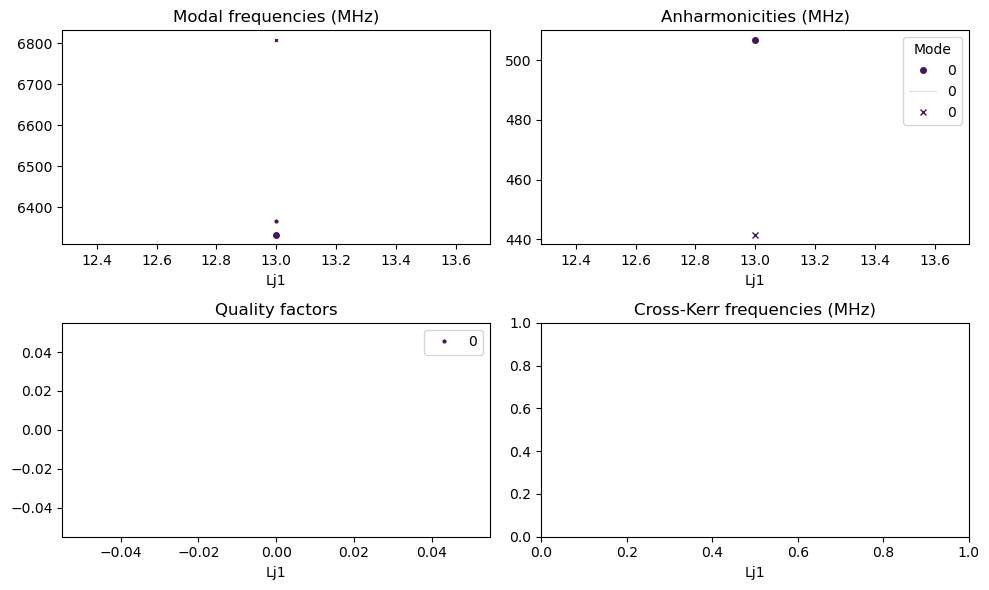

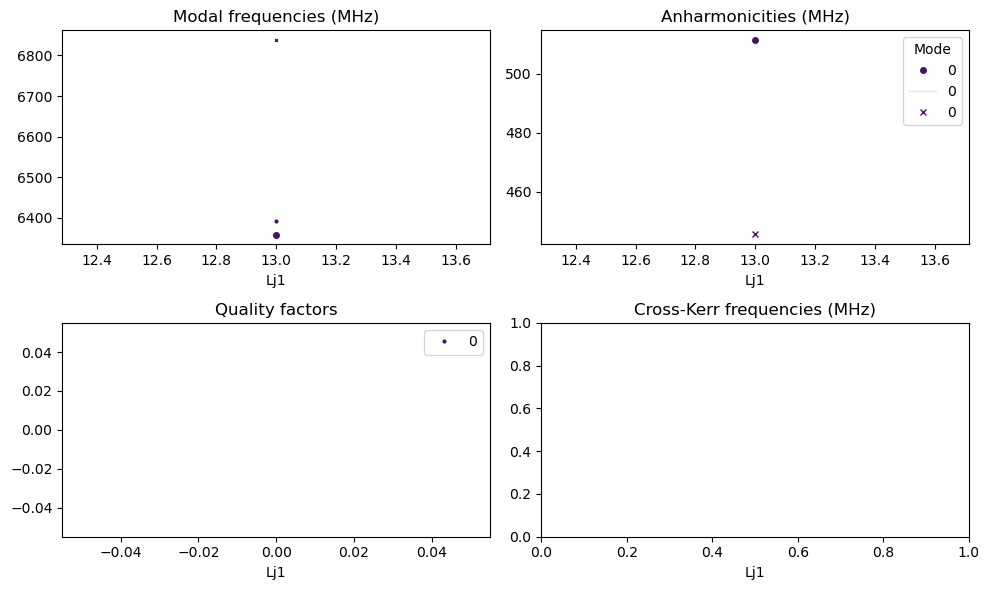

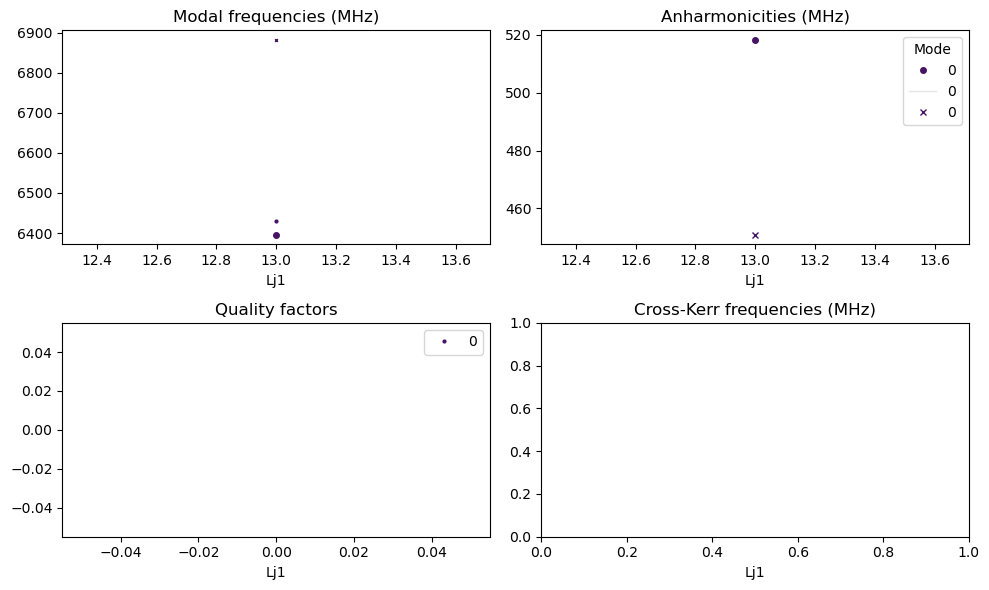

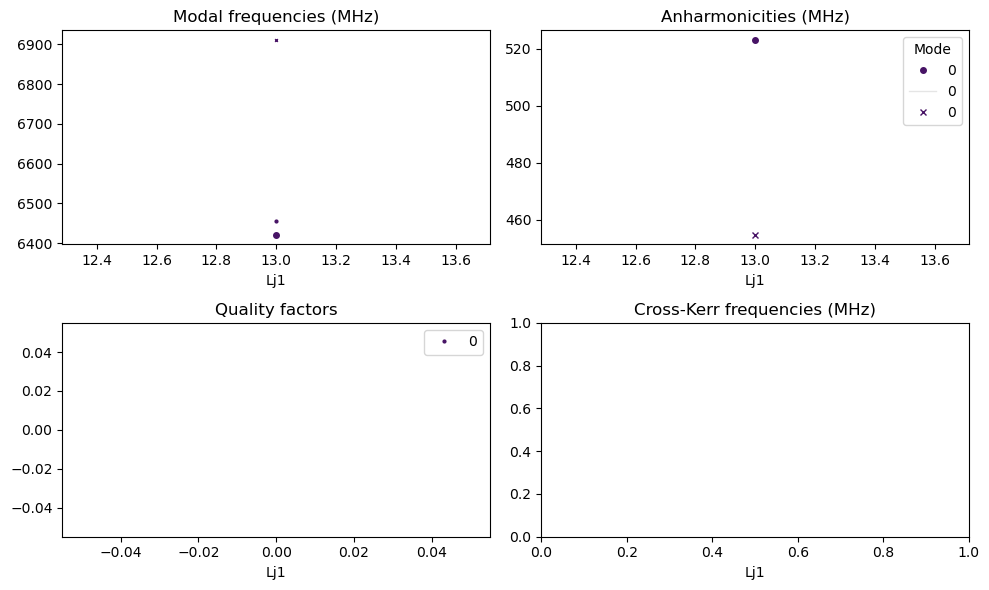

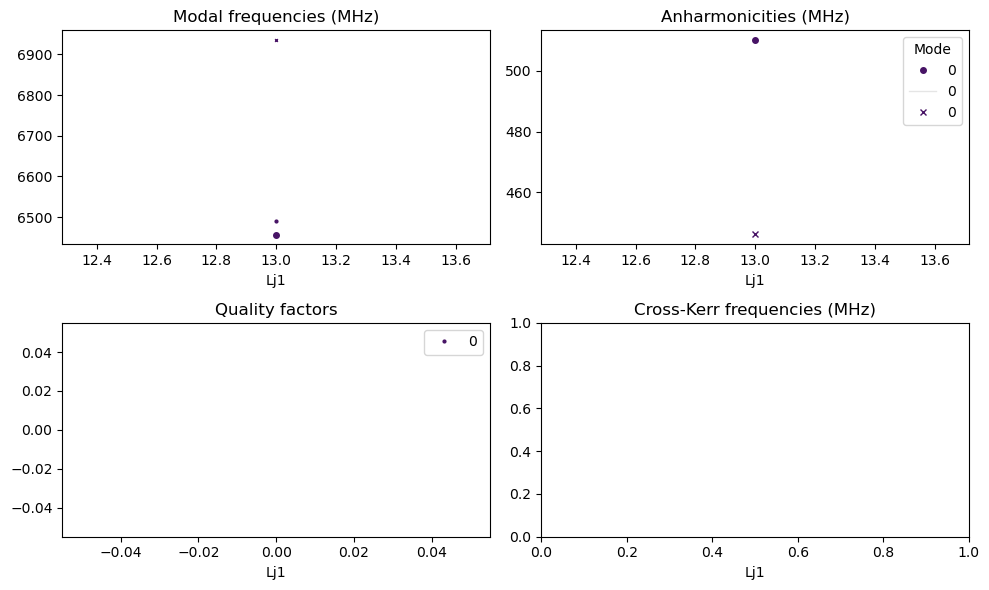

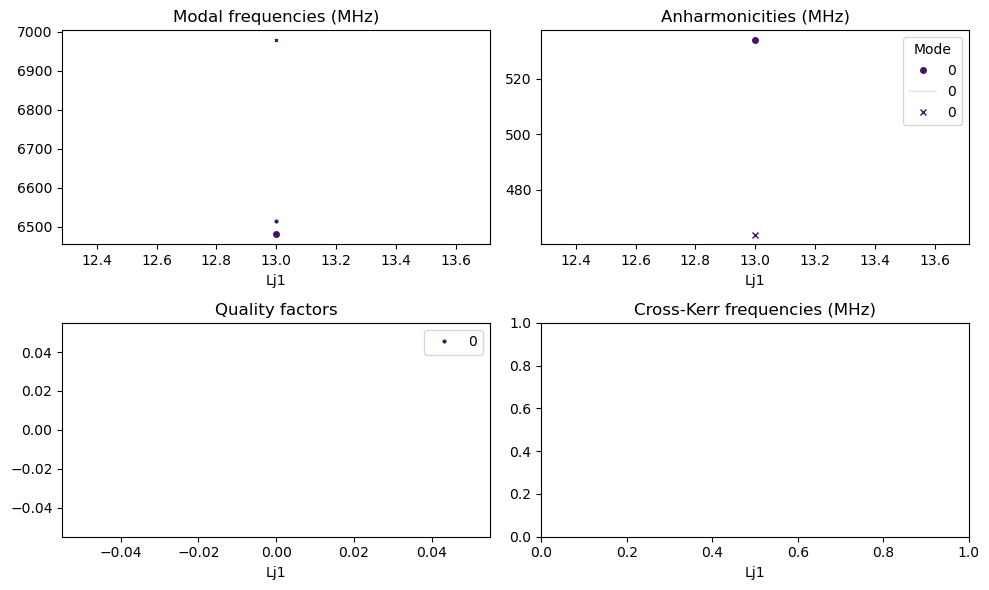

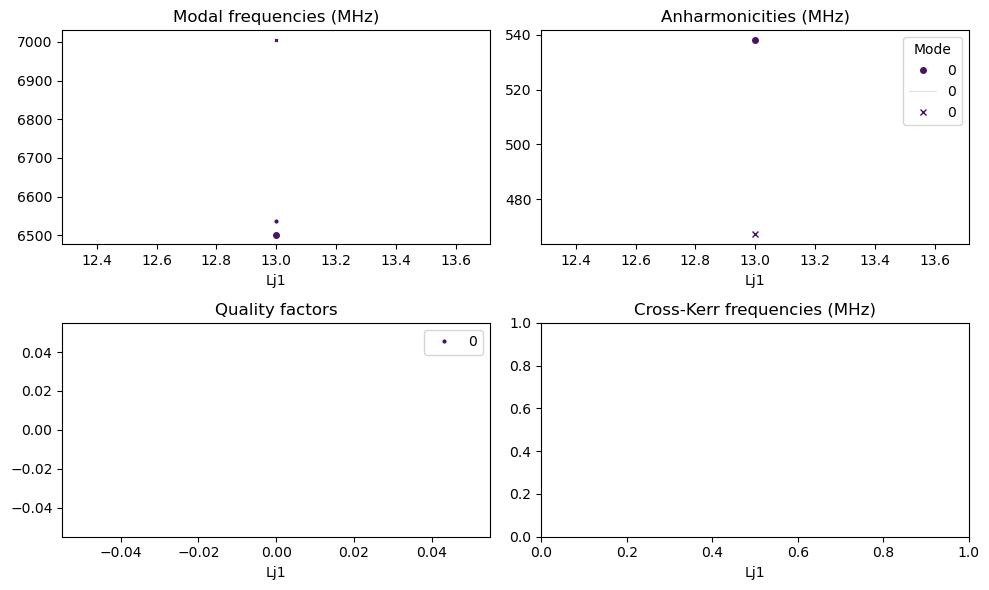

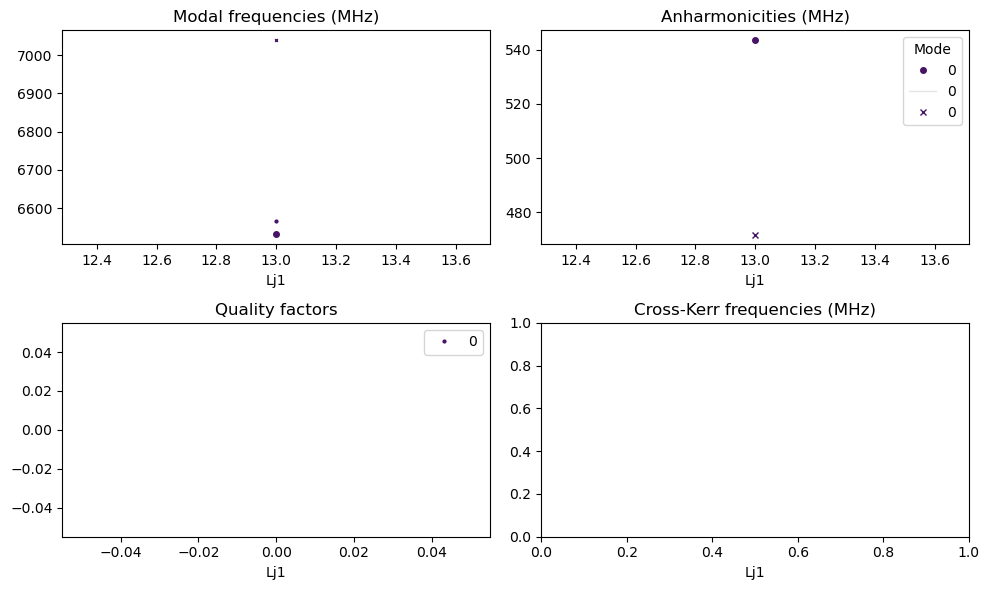

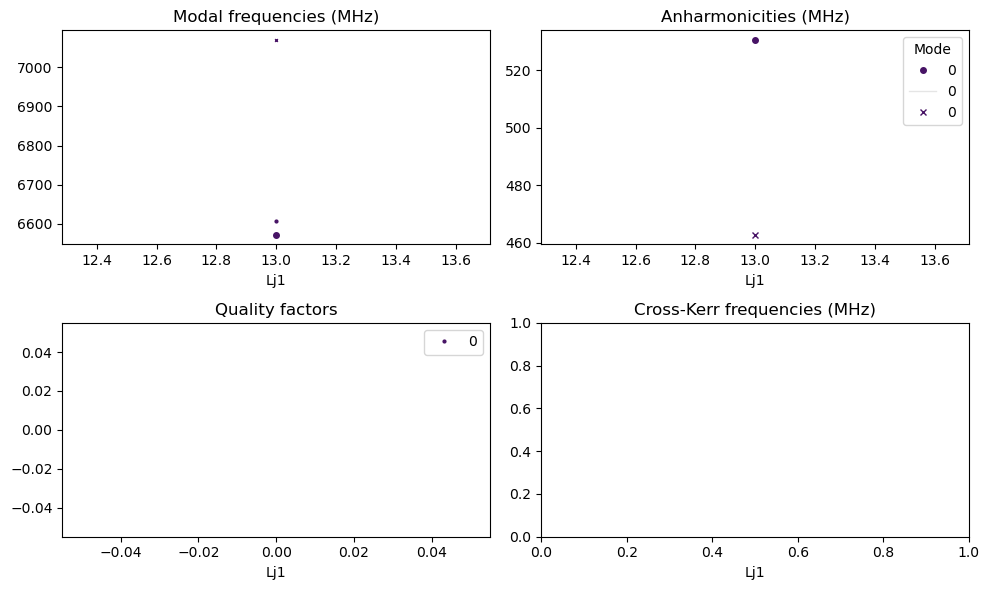

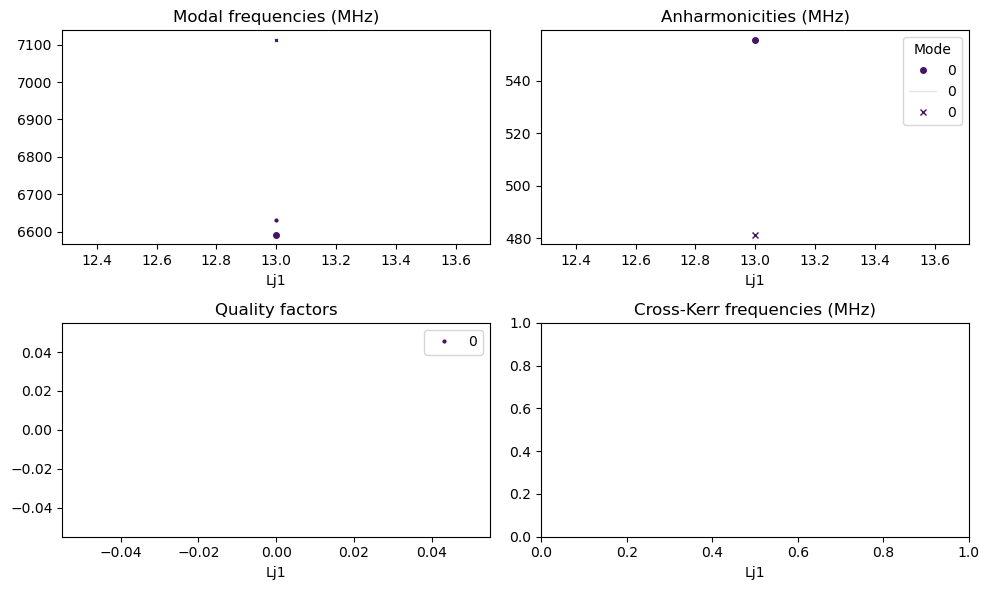

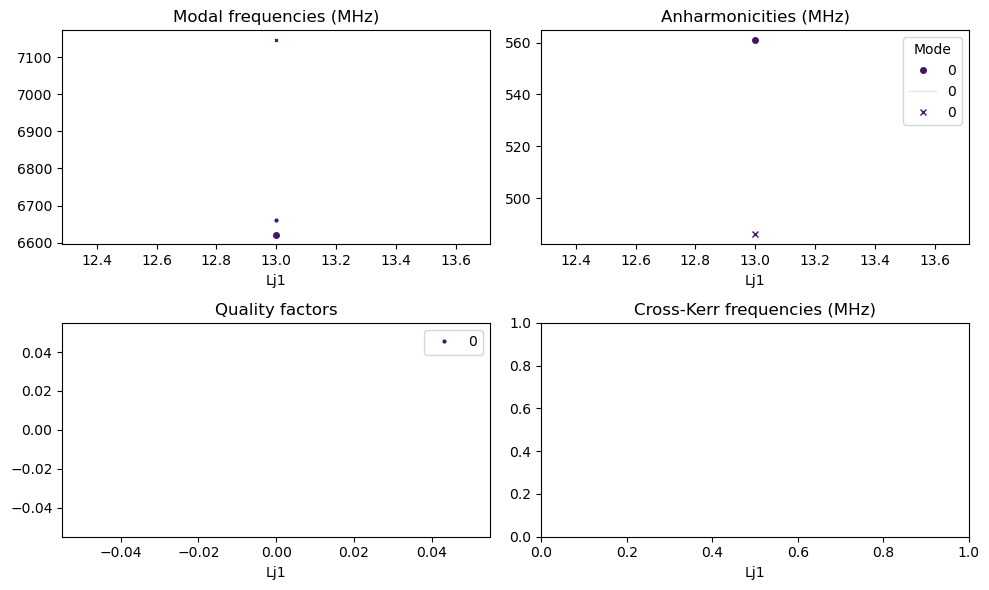

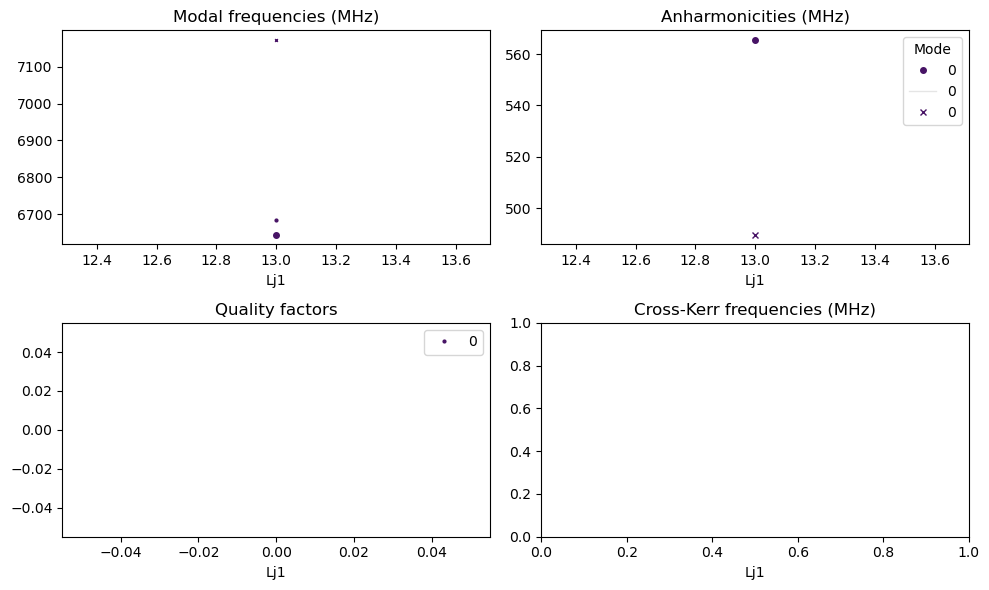

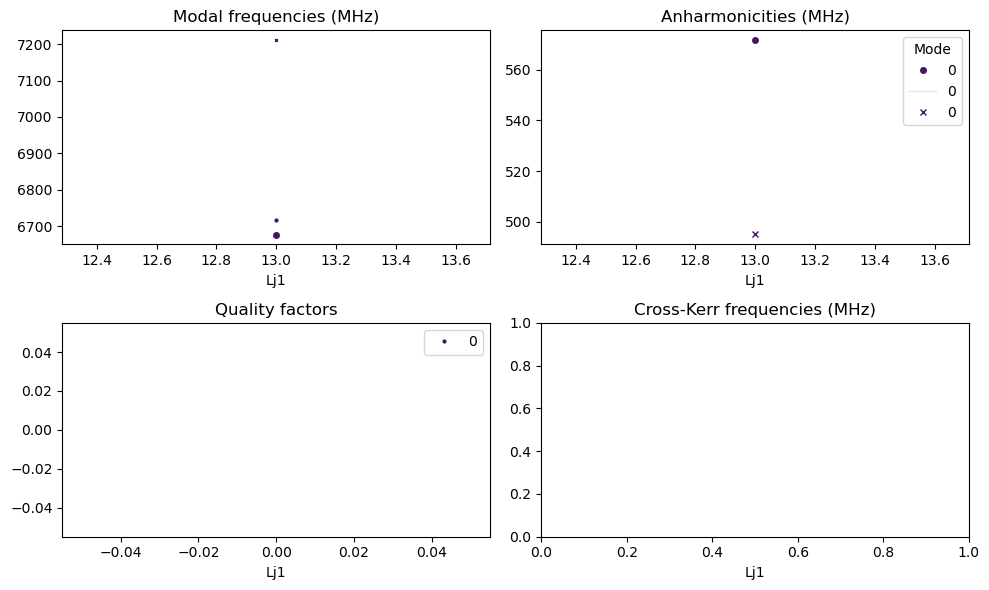

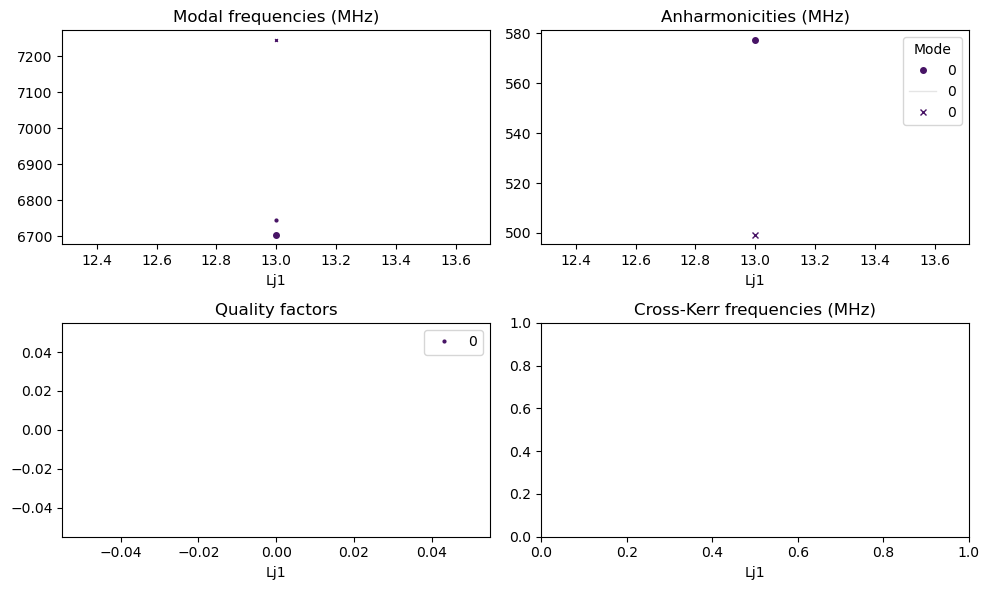

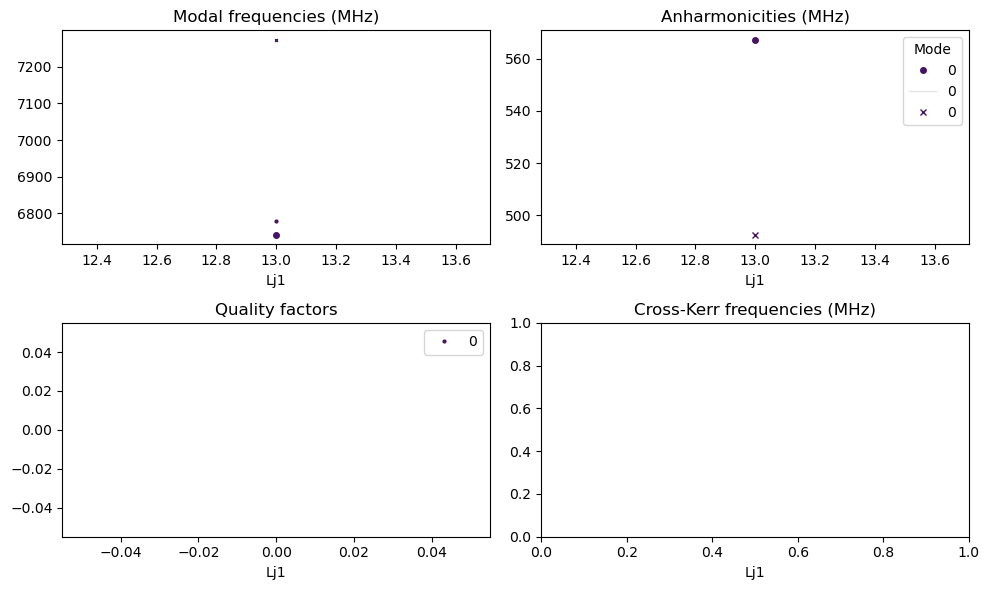

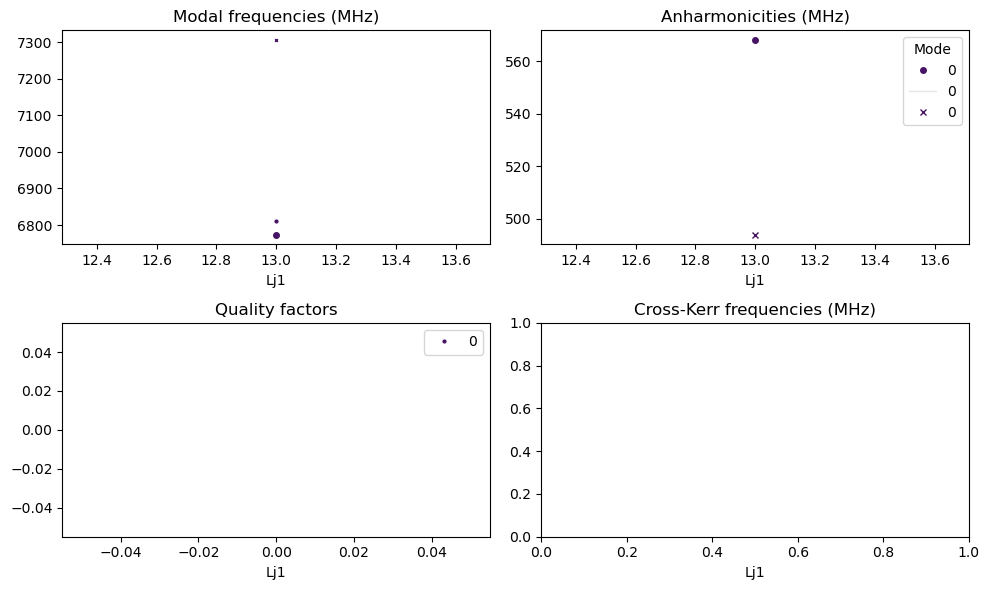

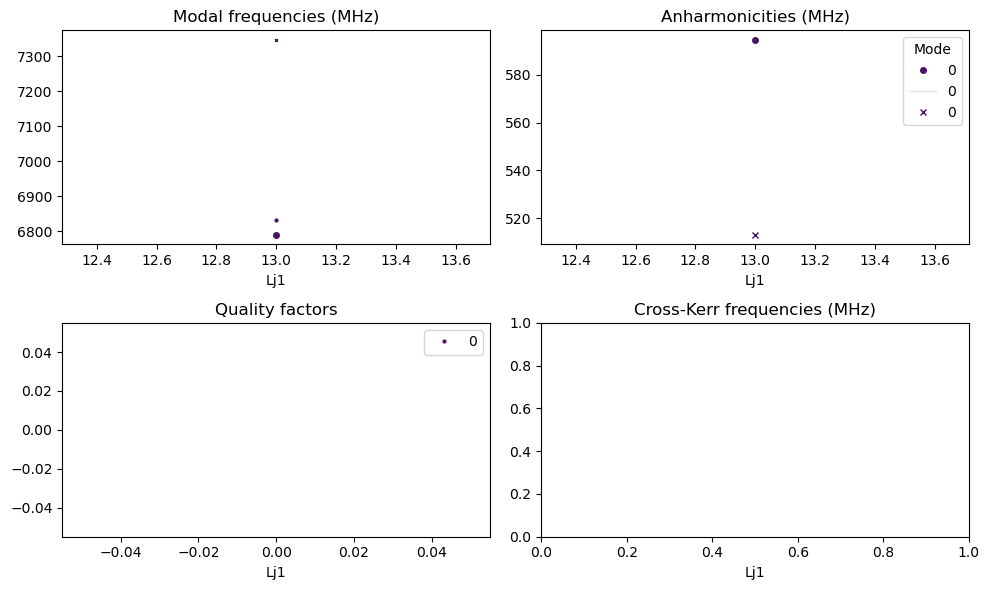

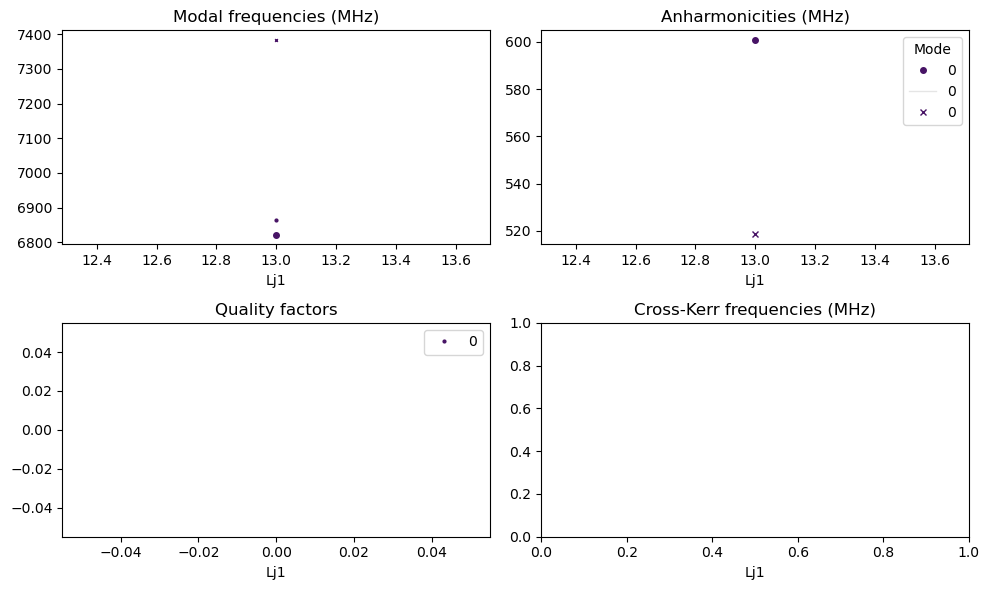

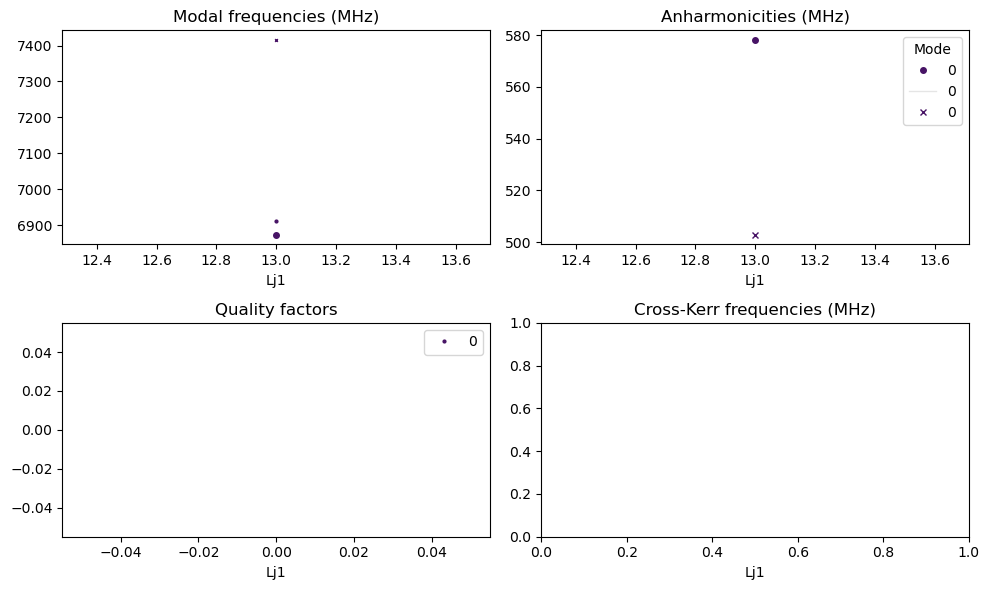

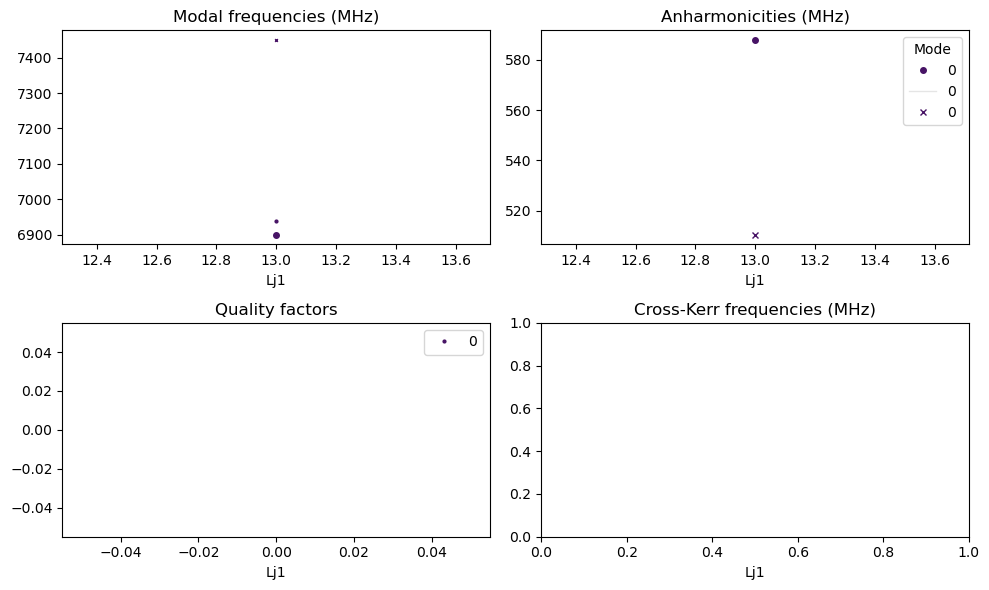

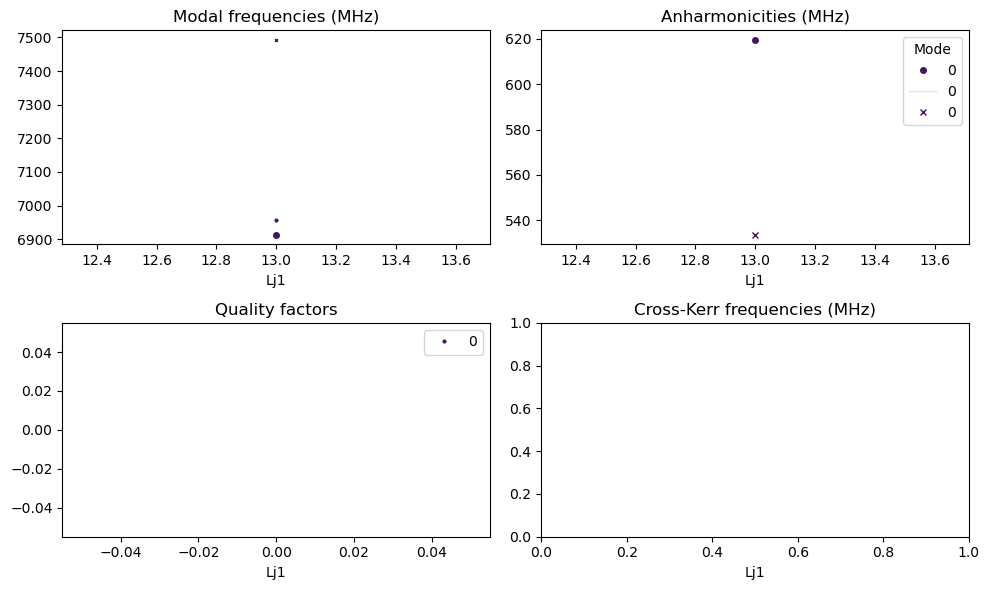

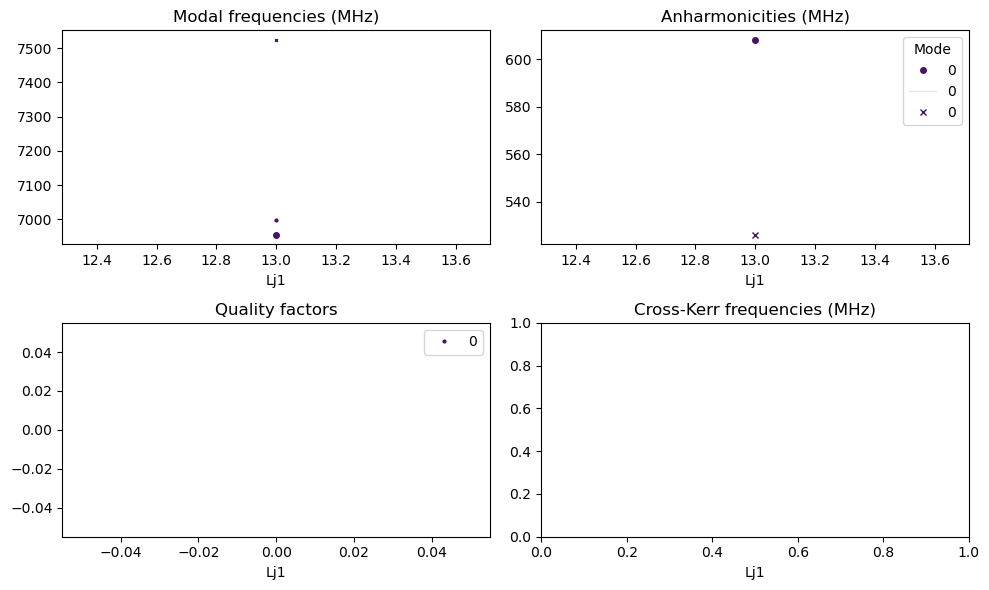

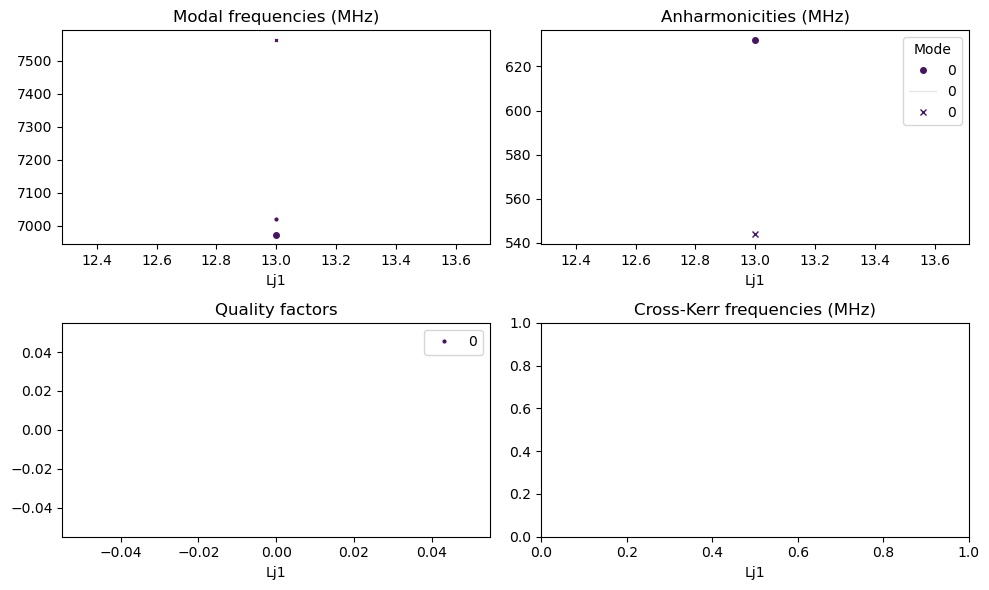

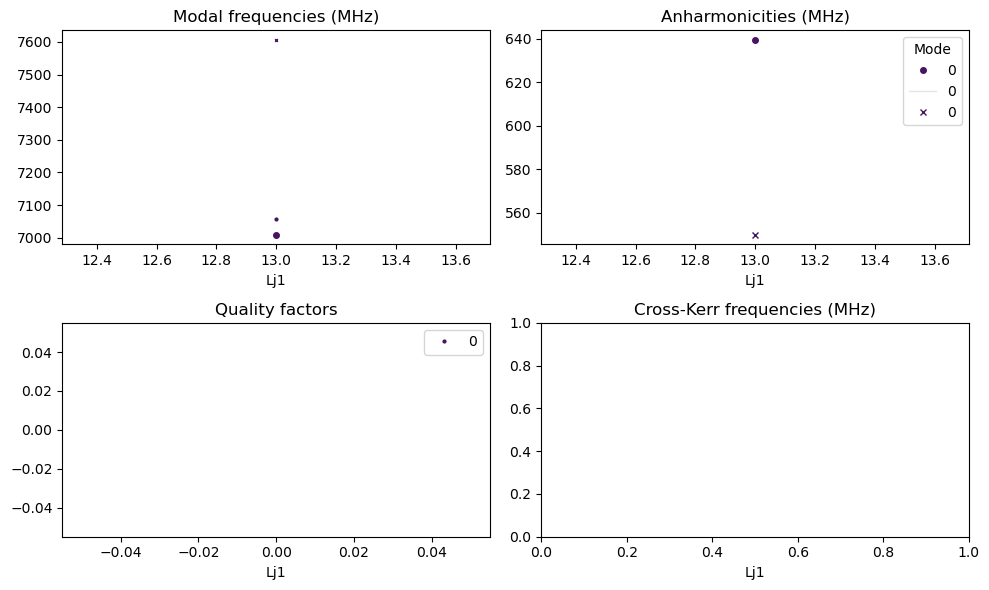

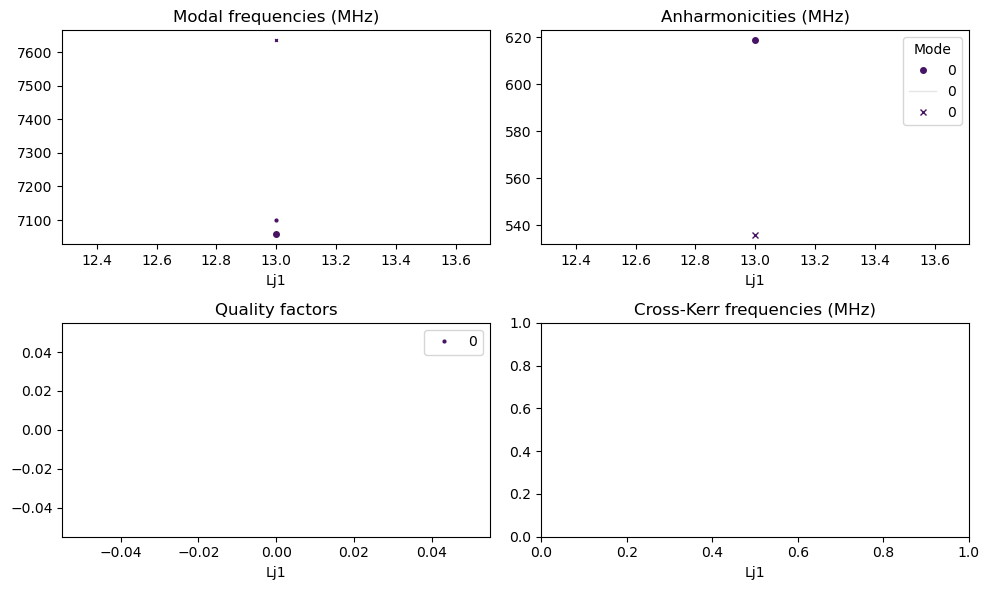

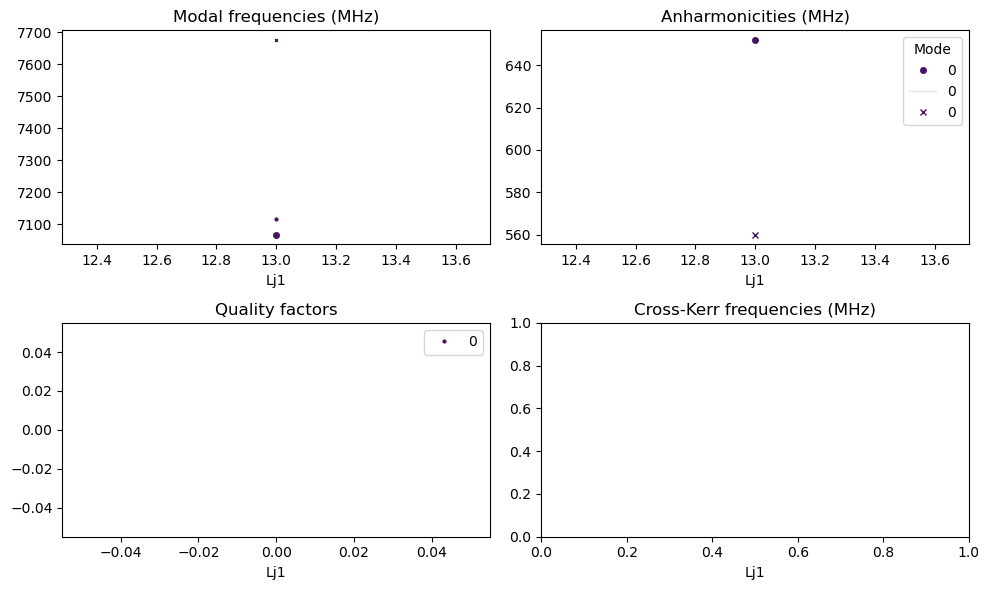

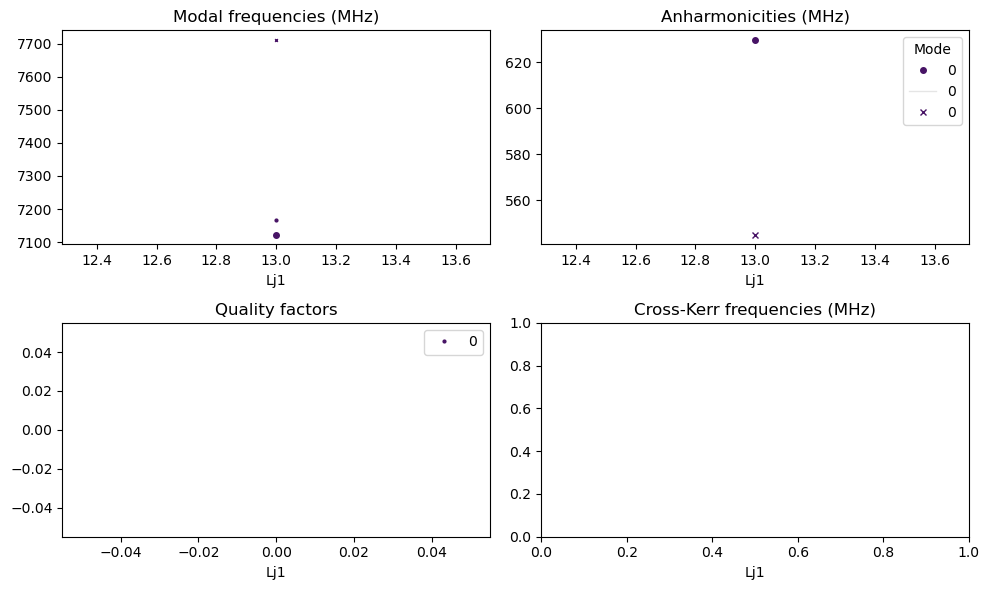

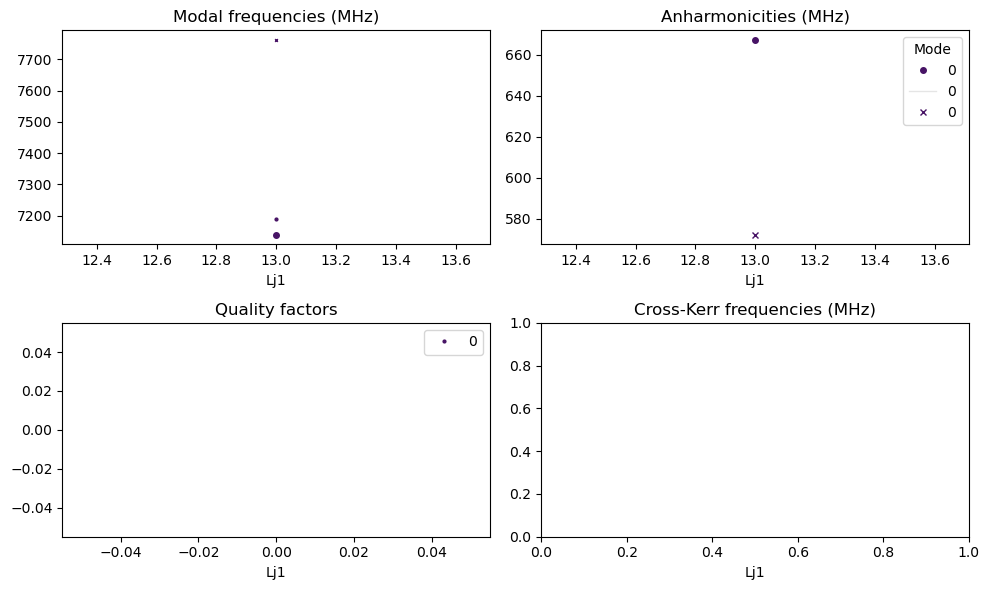

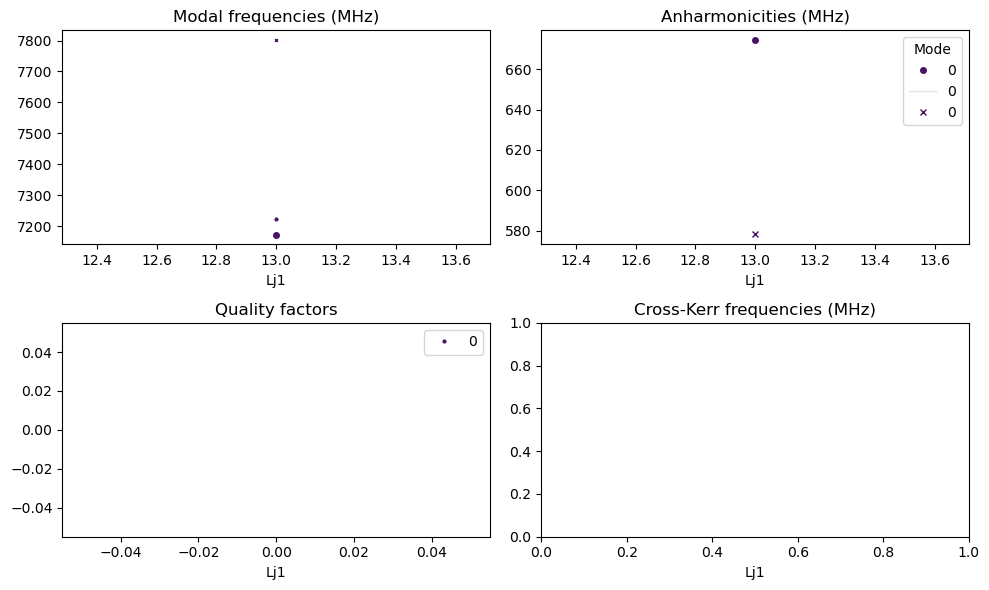

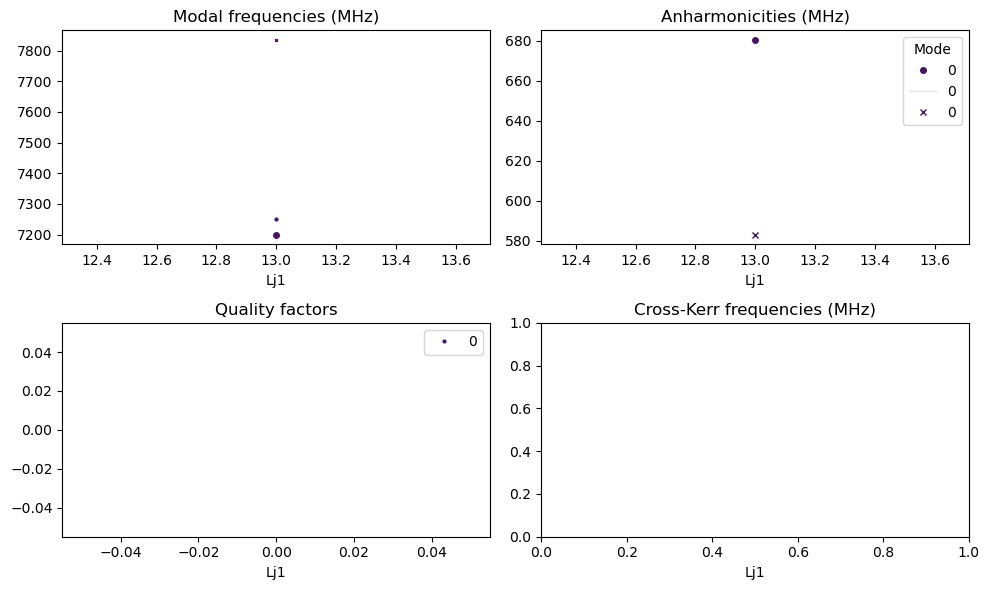

In [23]:
gap_min = 15
gap_max = 55

gaps = np.linspace(gap_min*u.um, gap_max*u.um, 30)
caps = []
convergences = []
dats = []
freqs = []


qcomps = design.components  # short handle (alias)
qcomps['Q1'].options['hfss_inductance'] = 'Lj1'
qcomps['Q1'].options['hfss_capacitance'] = 'Cj1'
gui.rebuild()  # line needed to propagate the updates from the qubit instance into the junction design table
gui.autoscale()

for i, gap in enumerate(gaps):
    capacitance, design = find_Cap(gap)
    caps += [capacitance]
    
    eig_qb = EPRanalysis(design, 'hfss')
    
    eig_qb.sim.setup.max_passes = 25
    eig_qb.sim.setup.max_delta_f = 0.05
    eig_qb.sim.setup.n_modes = 1
    eig_qb.sim.setup.vars = Dict(Lj1= '13 nH', Cj1= '0 fF')
    print(eig_qb.sim.setup)
    
    eig_qb.sim.renderer.options['x_buffer_width_mm'] = 0.5
    eig_qb.sim.renderer.options['y_buffer_width_mm'] = 0.5
    print(eig_qb.sim.renderer.options)
    
    eig_qb.sim.run(name="Transmons_{}".format(i), components=['Q1'], open_terminations=[('Q1', 'a')])
    convergence = pd.read_csv('hfss_eig_f_convergence.csv')
    convergences+=[convergence]
    
    del eig_qb.setup.junctions['jj']
    eig_qb.setup.junctions.jj1 = Dict(rect='JJ_rect_Lj_Q1_rect_jj', line='JJ_Lj_Q1_rect_jj_',
                  Lj_variable='Lj1', Cj_variable='Cj1')
    eig_qb.setup.sweep_variable = 'Lj1'
    eig_qb.run_epr()
    
    dats += [eig_qb.get_data()]
    freqs += [eig_qb.get_frequencies()]


The plot below shows that when we increase the distance to the two sides of the metal pads to the pocket edge, the capacitance decreases. In this simulation, we change the distance by changing the size of the metal pad in the pocket

In [24]:
plot_cap = []
plot_freq = []
plot_freq_epr = []

for i in range(30):
    
    plot_cap  += [caps[i].value]

    plot_freq += [pd.DataFrame.dropna(convergences[i])['re(Mode(1)) [g]'].values[-1]]
    
    plot_freq_epr += [freqs[i]['Freq. (GHz)'][0]]
    


In [25]:
%matplotlib inline

In [26]:
def freq_from_cap(Cq, lj = 13*u.nH):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = lj
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    
    return fq

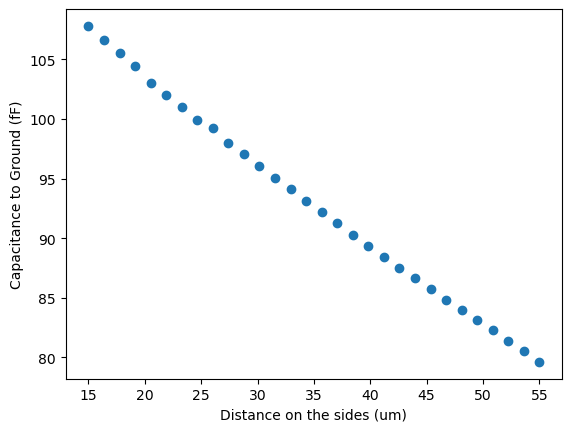

In [27]:
plt.figure()

plt.scatter(gaps.value, plot_cap)
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Capacitance to Ground (fF)')
plt.show()

In [28]:
plot_freq_from_cap = freq_from_cap(plot_cap)
plot_freq_from_cap1 = freq_from_cap(plot_cap,lj = 12*u.nH)

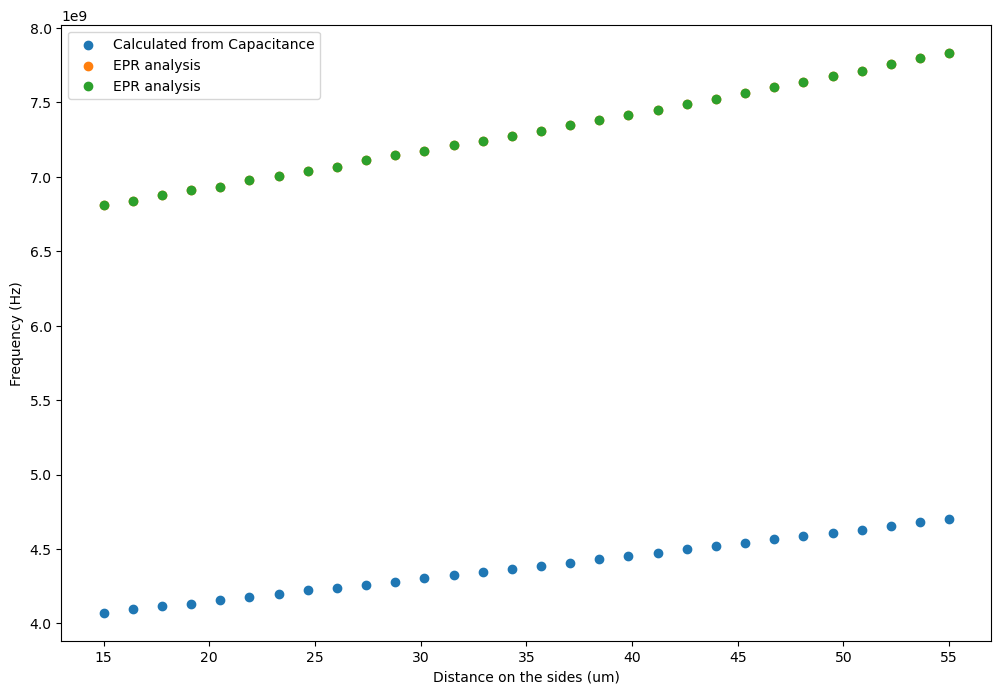

In [29]:
plt.figure(figsize = (12,8))

plt.scatter(gaps.value, plot_freq_from_cap,label =  'Calculated from Capacitance')
# plt.scatter(gaps.value, plot_freq_from_cap1)
plt.scatter(gaps.value, np.array(plot_freq)*1e9, label = 'EPR analysis')
plt.scatter(gaps.value, np.array(plot_freq_epr)*1e9, label = 'EPR analysis')
plt.xlabel('Distance on the sides (um)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.savefig('transmon frequency.png')
plt.show()



In [49]:
len(plot_freq_epr)

0

In [ ]:
stats.linregress(gaps.value)

In [67]:
# def find_Cap_h(height):
    height = height.to(u.um)
    design.delete_all_components()

    options = dict(pad_width = '250um',
    pocket_width = '300um',
    pad_pocket_distance_top = '40um',
    pos_x = '0',
    pad_height = '{}um'.format(height.value),
    pos_y = '0',
    connection_pads = dict(
        a = dict(loc_W  = 1, 
                loc_H =  1, 
                pad_gap = '10um',
                pad_height = '20um',
                pad_width = '100um',
                pad_cpw_extent =  '10um',
                pocket_rise = '0um',
                cpw_extend = '5um')))

    q1 = TransmonPocket_Single(design,'Q1',options = options)

    gui.rebuild()
    gui.zoom_on_components(['Q1'])
    
    
    c1 = LOManalysis(design, "q3d")
    c1.sim.setup.min_passes  = 10
    c1.sim.setup.max_passes = 20
    
    c1.sim.run(components=['Q1'], open_terminations=[('Q1', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
    c1.sim.capacitance_matrix 

    c1.sim._get_results_from_renderer()
    c_mat = c1.sim.capacitance_matrix
    
    print(c_mat)
    
    return(c_mat)

In [68]:
# heights = np.linspace(70*u.um, 240*u.um, 15)
# result_height = []
# for height in heights:
#     result_height += [find_Cap_h(height)]

INFO 03:08PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 03:08PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:08PM [analyze]: Analyzing setup Setup


The plot below shows that if we make the pocket longer, where we also make the metal pad longer, then the capacitance increases

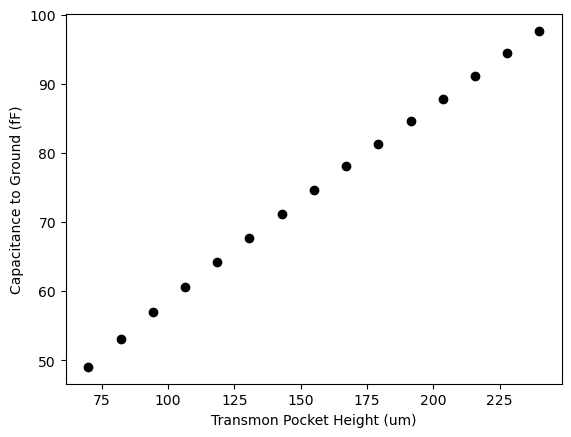

In [70]:
# for i, r in enumerate(result_height):
#     plt.scatter(heights[i], -r['pad_top_Q1']['ground_main_plane'],color = 'black')
# plt.xlabel('Transmon Pocket Height (um)')
# plt.ylabel('Capacitance to Ground (fF)')
# plt.show()

### Function that takes in frequency and construct qubit design automatically

In [18]:
phi0 = c.h/2/c.e.si
T = 30*u.mK
epsilon_r = 11.7

In [69]:
def transmon_capacitance(Cq, lj =12*u.nH ):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = lj
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq)

In [70]:
def transmon_capacitance_optimzie(Cq, target_freq):
    Cq *= u.fF
    # Cq = 100*u.fF
    Lj = 12*u.nH
    Ec = (c.e.si**2/2/Cq).to(u.J)
    Ej = ((phi0/2/np.pi)**2/Lj).to(u.J)
    # epsilon1 = -Ec*2**9
    wq = (np.sqrt(8*Ej*Ec)-Ec)/c.hbar
    fq = wq/2/np.pi
    alpha = Ec/c.h
    
    return(fq-target_freq)

In [71]:
transmon_capacitance(120)

<Quantity 4.03268243e+09 1 / s>

In [61]:
target_freq = 4.5*u.GHz



target_cap = optimize.fsolve(transmon_capacitance_optimzie,100, args = (target_freq))[0]*u.fF


In [62]:
target_cap

<Quantity 87.40045862 fF>

In [25]:
def simulate_cap_minimize(width):
    return(find_Cap(width)-target_cap)

# width_45 = optimize.fsolve(simulate_cap_minimize, [250])

In [31]:
find_Cap(6*u.GHz)

UnitConversionError: 'GHz' (frequency) and 'um' (length) are not convertible

In [94]:
type(2*u.m)

astropy.units.quantity.Quantity

NameError: name 'width' is not defined

In [57]:
optimize.show_options()




minimize


bfgs
====

Minimization of scalar function of one or more variables using the
BFGS algorithm.

Options
-------
disp : bool
    Set to True to print convergence messages.
maxiter : int
    Maximum number of iterations to perform.
gtol : float
    Terminate successfully if gradient norm is less than `gtol`.
norm : float
    Order of norm (Inf is max, -Inf is min).
eps : float or ndarray
    If `jac is None` the absolute step size used for numerical
    approximation of the jacobian via forward differences.
return_all : bool, optional
    Set to True to return a list of the best solution at each of the
    iterations.
finite_diff_rel_step : None or array_like, optional
    If `jac in ['2-point', '3-point', 'cs']` the relative step size to
    use for numerical approximation of the jacobian. The absolute step
    size is computed as ``h = rel_step * sign(x) * max(1, abs(x))``,
    possibly adjusted to fit into the bounds. For ``method='3-point'``
    the sign of `h` is ignore